In [2]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [3]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [4]:
def preprocess(df, kinship: str):
    df.columns = [x[:len(x) // 2] for x in df.columns]  # fix duplicated column names
    df.index = df.columns
    df.index.name = 'Hybrid'
    df.columns = [f'{x}_{kinship}' for x in df.columns]
    return df

In [5]:
# targets
ytrain = pd.read_csv('../output/ytrain.csv')
yval = pd.read_csv('../output/yval.csv')

# kinships
A = pd.read_csv('../output/kinship_additive.txt', sep='\t')
A = preprocess(A, 'A')
D = pd.read_csv('../output/kinship_dominant.txt', sep='\t')
D = preprocess(D, 'D')
K = pd.concat([A, D], axis=1)

# merge
xtrain = pd.merge(ytrain, K, on='Hybrid', how='left').dropna().set_index(['Env', 'Hybrid'])
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']
xval = pd.merge(yval, K, on='Hybrid', how='left').dropna().set_index(['Env', 'Hybrid'])
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

xtrain

2369/DK3IIH6_A  2369/PHN82_A  2369/PHZ51_A  \
Env       Hybrid                                                          
DEH1_2020 B14A/H95                -0.026247     -0.047853     -0.041818   
          B14A/MO17               -0.068198     -0.068276     -0.025328   
          B14A/OH43               -0.028423     -0.070412     -0.058964   
          B37/H95                 -0.109742     -0.142076     -0.129848   
          B37/MO17                -0.150514     -0.162173     -0.112959   
...                                     ...           ...           ...   
WIH3_2020 W10004_1123/PHP02        0.163367      0.231043     -0.140481   
          W10004_1140/PHP02        0.141772      0.204840     -0.122336   
          W10004_1143/PHP02        0.090605      0.147723     -0.175186   
          W10004_1146/PHP02        0.148772      0.201161     -0.125527   
          W10004_1156/PHP02        0.163689      0.238922     -0.119241   

                             2FACC/DK3IIH6_A  4N506/DK3IIH6_A  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                 -0.017140         0.016445   
          B14A/MO17                -0.025104        -0.003441   
          B14A/OH43                -0.015610         0.011026   
          B37/H95                  -0.051898        -0.079119   
          B37/MO17                 -0.059293        -0.098021   
...                                      ...              ...   
WIH3_2020 W10004_1123/PHP02         0.271972         0.176680   
          W10004_1140/PHP02         0.201639         0.165544   
          W10004_1143/PHP02         0.210570         0.119107   
          W10004_1146/PHP02         0.223341         0.195072   
          W10004_1156/PHP02         0.233674         0.168883   

                             6F629/DK3IIH6_A  740/PB80_A  740/PHB47_A  \
Env       Hybrid                                                        
DEH1_2020 B14A/H95                 -0.015076    0.006943    -0.028534   
          B14A/MO17                -0.055442    0.410404     0.373756   
          B14A/OH43                -0.022787   -0.010251    -0.039121   
          B37/H95                   0.090355   -0.129117     0.232471   
          B37/MO17                  0.049266    0.273962     0.633599   
...                                      ...         ...          ...   
WIH3_2020 W10004_1123/PHP02         0.188630   -0.103618    -0.093625   
          W10004_1140/PHP02         0.158160   -0.052047    -0.056024   
          W10004_1143/PHP02         0.169529   -0.087903     0.013542   
          W10004_1146/PHP02         0.171060   -0.077668    -0.095470   
          W10004_1156/PHP02         0.175591   -0.075600    -0.094182   

                             A632/DK3IIH6_A  A634/DK3IIH6_A  ...  \
Env       Hybrid                                             ...   
DEH1_2020 B14A/H95                 0.018738        0.008507  ...   
          B14A/MO17               -0.027943       -0.028982  ...   
          B14A/OH43                0.011052        0.006331  ...   
          B37/H95                 -0.041766       -0.044756  ...   
          B37/MO17                -0.086366       -0.081286  ...   
...                                     ...             ...  ...   
WIH3_2020 W10004_1123/PHP02        0.309995        0.286184  ...   
          W10004_1140/PHP02        0.189463        0.171698  ...   
          W10004_1143/PHP02        0.194371        0.184433  ...   
          W10004_1146/PHP02        0.264339        0.239260  ...   
          W10004_1156/PHP02        0.229641        0.222555  ...   

                             Z036E0057/PHZ51_D  Z037E0012/DK3IIH6_D  \
Env       Hybrid                                                      
DEH1_2020 B14A/H95                    0.016399             0.005801   
          B14A/MO17                   0.044549             0.029054   
          B14A/OH43                   0.014996             0.017779   
          B37/H95

### Training

In [6]:
%%time

NCOLS = xtrain.shape[1]
print('features:', NCOLS)

model = lgbm.LGBMRegressor(random_state=42)
model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# predict
ypred = model.predict(xval.iloc[:, :NCOLS])

# validate
df_eval = pd.DataFrame()
df_eval['Env'] = xval.index.get_level_values(0)
df_eval['ytrue'] = list(yval)
df_eval['ypred'] = ypred
rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group)

rmse = sum(rmse_per_group) / len(rmse_per_group)
print('RMSE:', rmse)

features: 9856
Env
COH1_2021    2.104795
DEH1_2021    2.366975
GAH1_2021    1.706518
GAH2_2021    3.717533
GEH1_2021    3.023810
IAH1_2021    1.429503
IAH2_2021    2.222976
IAH3_2021    2.450600
IAH4_2021    1.658930
ILH1_2021    2.339910
INH1_2021    1.602712
MIH1_2021    2.199460
MNH1_2021    1.377248
NCH1_2021    1.882798
NEH1_2021    3.078551
NEH2_2021    2.749183
NEH3_2021    4.740066
NYH2_2021    2.122447
NYH3_2021    2.198249
NYS1_2021    1.905490
SCH1_2021    2.942411
TXH1_2021    1.774281
TXH2_2021    1.751285
TXH3_2021    5.384151
WIH1_2021    3.083380
WIH2_2021    3.151611
WIH3_2021    1.580890
dtype: float64
RMSE: 2.4646578851643137
CPU times: user 3min 49s, sys: 2.38 s, total: 3min 52s
Wall time: 3min 52s


-0.01947756262643674


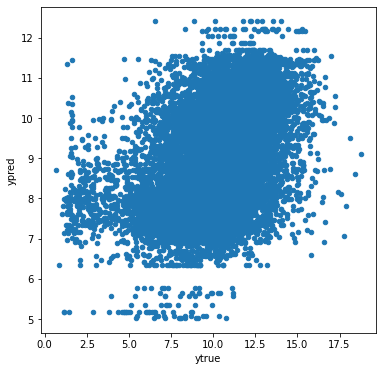

In [7]:
print(r2_score(df_eval['ytrue'], df_eval['ypred']))
df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [8]:
from sklearn.decomposition import TruncatedSVD

In [9]:
%%time

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.9914947918792714
CPU times: user 8.25 s, sys: 544 ms, total: 8.79 s
Wall time: 8.87 s


In [10]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'svd{i}' for i in range(n_components)]

CPU times: user 1.91 s, sys: 425 ms, total: 2.33 s
Wall time: 2.34 s


In [11]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [12]:
xtrain_svd

svd0       svd1      svd2      svd3  \
Env       Hybrid                                                       
DEH1_2020 B14A/H95           0.379751  -0.473513  0.962836  0.692138   
          B14A/MO17          2.044380  -0.678291  2.169184  1.255659   
          B14A/OH43          0.341187  -1.037611  1.812648  1.131168   
          B37/H95           -0.095678  -0.287640  1.566099 -3.419511   
          B37/MO17           1.598063  -0.487787  2.764974 -2.854961   
...                               ...        ...       ...       ...   
WIH3_2020 W10004_1123/PHP02 -4.746587  12.032103 -0.145061 -1.324332   
          W10004_1140/PHP02 -3.928082  11.192637  0.192099  0.611796   
          W10004_1143/PHP02 -4.095832  11.107945  0.648170 -1.524607   
          W10004_1146/PHP02 -3.888436  11.433986  0.474083  0.191084   
          W10004_1156/PHP02 -4.338665  11.000610  0.040648  0.283418   

                                 svd4      svd5      svd6      svd7      svd8  \
Env       Hybrid                                                                
DEH1_2020 B14A/H95           0.348412  2.036888  2.567666  0.368109 -0.245233   
          B14A/MO17          0.137435  5.859281 -1.856766  1.424492 -0.204847   
          B14A/OH43          0.577527  2.311015  3.234372  0.474354 -0.216201   
          B37/H95            5.395529  0.706886  2.195090  0.312326 -0.123882   
          B37/MO17           5.241457  4.461887 -2.119644  1.386883 -0.367537   
...                               ...       ...       ...       ...       ...   
WIH3_2020 W10004_1123/PHP02 -1.901656 -0.183033  0.275189 -0.084166  0.685990   
          W10004_1140/PHP02  0.042068  0.352617  0.092853 -0.305520  0.273936   
          W10004_1143/PHP02  0.793079  0.431859 -0.218629 -0.239751  0.605116   
          W10004_1146/PHP02 -0.713410  0.148259  0.051184  0.006247 -0.003330   
          W10004_1156/PHP02 -0.856379  0.167509 -0.106639  0.636598  0.449002   

                                 svd9  ...     svd96     svd97     svd98  \
Env       Hybrid                       ...                                 
DEH1_2020 B14A/H95           0.681755  ...  0.175805  0.044211  0.091924   
          B14A/MO17         -0.597917  ...  0.054220  0.026192  0.038912   
          B14A/OH43          0.879487  ... -0.062475 -0.137308  0.133943   
          B37/H95            0.614240  ...  0.169827  0.122166 -0.092525   
          B37/MO17          -0.624286  ...  0.038778  0.123587  0.047209   
...                               ...  ...       ...       ...       ...   
WIH3_2020 W10004_1123/PHP02 -1.351979  ...  0.106567 -0.064481 -0.047633   
          W10004_1140/PHP02 -0.415001  ... -0.096735 -0.143846  0.114082   
          W10004_1143/PHP02  0.071101  ...  0.134731 -0.192771  0.098809   
          W10004_1146/PHP02  0.061853  ... -0.011773  0.073291  0.095245   
          W10004_1156/PHP02 -0.317771  ... -0.009460 -0.044538 -0.074577   

                                svd99  mean_yield_lag_2  min_yield_lag_2  \
Env       Hybrid                                                           
DEH1_2020 B14A/H95           0.235204         10.056423         0.725594   
          B14A/MO17          0.099329         10.056423         0.725594   
          B14A/OH43         -0.126589         10.056423         0.725594   
          B37/H95            0.190987         10.056423         0.725594   
          B37/MO17          -0.003355         10.056423         0.725594   
...                               ...               ...              ...   
WIH3_2020 W10004_1123/PHP02 -0.043030          9.010208         1.129919   
          W10004_1140/PHP02 -0.114042          9.010208         1.129919   
          W10004_1143/PHP02 -0.077536          9.010208         1.129919   
          W10004_1146/PHP02  0.102995          9.010208         1.129919   
          W10004_1156/PHP02 -0.040877          9.010208         1.129919   

                             p1_yield_lag_2  q1_yield_lag_2  q3_

In [13]:
import optuna

In [14]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-02-13 16:05:40,205] A new study created in memory with name: no-name-8f85a8a2-532e-49d9-9408-fa129b689bd0


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.839196365086843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.839196365086843
[LightGBM] [Warning] feature_fraction is set=0.3745401188473625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3745401188473625
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-02-13 16:05:40,551] Trial 0 finished with value: 2.3235734408217765 and parameters: {'feature_fraction': 0.3745401188473625, 'num_leaves': 244, 'bagging_fraction': 0.839196365086843, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.3235734408217765.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.8248435466776274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8248435466776274
[LightGBM] [Warning] feature_fraction is set=0.8661761457749352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661761457749352
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-02-13 16:05:41,899] Trial 1 finished with value: 2.215453434991862 and parameters: {'feature_fraction': 0.8661761457749352, 'num_leaves': 155, 'bagging_fraction': 0.8248435466776274, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.215453434991862.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.5825453457757226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5825453457757226
[LightGBM] [Warning] feature_fraction is set=0.18182496720710062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18182496720710062
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-02-13 16:05:42,478] Trial 2 finished with value: 2.2583692210604536 and parameters: {'feature_fraction': 0.18182496720710062, 'num_leaves': 48, 'bagging_fraction': 0.5825453457757226, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 1 with value: 2.215453434991862.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] feature_fraction is set=0.13949386065204183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13949386065204183
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-02-13 16:05:42,866] Trial 3 finished with value: 2.2333784092198465 and parameters: {'feature_fraction': 0.13949386065204183, 'num_leaves': 76, 'bagging_fraction': 0.619817105976215, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 1 with value: 2.215453434991862.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.764526911140863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.764526911140863
[LightGBM] [Warning] feature_fraction is set=0.5924145688620425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924145688620425
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-02-13 16:05:44,569] Trial 4 finished with value: 2.237184100129502 and parameters: {'feature_fraction': 0.5924145688620425, 'num_leaves': 13, 'bagging_fraction': 0.764526911140863, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 1 with value: 2.215453434991862.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.45860326840383037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45860326840383037
[LightGBM] [Warning] feature_fraction is set=0.8083973481164611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083973481164611
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-02-13 16:05:45,132] Trial 5 finished with value: 2.3135124326385306 and parameters: {'feature_fraction': 0.8083973481164611, 'num_leaves': 79, 'bagging_fraction': 0.45860326840383037, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 1 with value: 2.215453434991862.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.5552679889600102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552679889600102
[LightGBM] [Warning] feature_fraction is set=0.034388521115218396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.034388521115218396
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-02-13 16:05:45,586] Trial 6 finished with value: 2.2090146501491192 and parameters: {'feature_fraction': 0.034388521115218396, 'num_leaves': 233, 'bagging_fraction': 0.5552679889600102, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 6 with value: 2.2090146501491192.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8650796940166687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8650796940166687
[LightGBM] [Warning] feature_fraction is set=0.18485445552552704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18485445552552704
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-02-13 16:05:46,682] Trial 7 finished with value: 2.293509534785697 and parameters: {'feature_fraction': 0.18485445552552704, 'num_leaves': 249, 'bagging_fraction': 0.8650796940166687, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 6 with value: 2.2090146501491192.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.4271363733463229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4271363733463229
[LightGBM] [Warning] feature_fraction is set=0.0884925020519195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884925020519195
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-02-13 16:05:47,192] Trial 8 finished with value: 2.17626756265844 and parameters: {'feature_fraction': 0.0884925020519195, 'num_leaves': 51, 'bagging_fraction': 0.4271363733463229, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.7256176498949491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256176498949491
[LightGBM] [Warning] feature_fraction is set=0.3567533266935893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3567533266935893
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-02-13 16:05:47,706] Trial 9 finished with value: 2.2402955556164037 and parameters: {'feature_fraction': 0.3567533266935893, 'num_leaves': 73, 'bagging_fraction': 0.7256176498949491, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=1.3232991168593193e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232991168593193e-05
[LightGBM] [Warning] bagging_fraction is set=0.4045283915897759, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4045283915897759
[LightGBM] [Warning] feature_fraction is set=0.020652387802087196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.020652387802087196
[LightGBM] [Warning] lambda_l2 is set=0.005764962972197537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005764962972197537


[I 2023-02-13 16:05:48,159] Trial 10 finished with value: 2.2227751583251187 and parameters: {'feature_fraction': 0.020652387802087196, 'num_leaves': 143, 'bagging_fraction': 0.4045283915897759, 'lambda_l1': 1.3232991168593193e-05, 'lambda_l2': 0.005764962972197537, 'n_estimators': 120, 'max_depth': 5}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.045549901978910304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045549901978910304
[LightGBM] [Warning] bagging_fraction is set=0.5178281740292456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5178281740292456
[LightGBM] [Warning] feature_fraction is set=0.006383103434000781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006383103434000781
[LightGBM] [Warning] lambda_l2 is set=3.587017613246042e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.587017613246042e-06


[I 2023-02-13 16:05:48,586] Trial 11 finished with value: 2.3479212862501693 and parameters: {'feature_fraction': 0.006383103434000781, 'num_leaves': 191, 'bagging_fraction': 0.5178281740292456, 'lambda_l1': 0.045549901978910304, 'lambda_l2': 3.587017613246042e-06, 'n_estimators': 183, 'max_depth': 3}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=1.5933523153411743e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5933523153411743e-05
[LightGBM] [Warning] bagging_fraction is set=0.5134256426269105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5134256426269105
[LightGBM] [Warning] feature_fraction is set=0.2622713788133536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2622713788133536
[LightGBM] [Warning] lambda_l2 is set=5.0329419692858124e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0329419692858124e-06


[I 2023-02-13 16:05:49,415] Trial 12 finished with value: 2.2491410395142704 and parameters: {'feature_fraction': 0.2622713788133536, 'num_leaves': 194, 'bagging_fraction': 0.5134256426269105, 'lambda_l1': 1.5933523153411743e-05, 'lambda_l2': 5.0329419692858124e-06, 'n_estimators': 146, 'max_depth': 5}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.17830906543125621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17830906543125621
[LightGBM] [Warning] bagging_fraction is set=0.6324942527133204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6324942527133204
[LightGBM] [Warning] feature_fraction is set=0.012796532875912023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012796532875912023
[LightGBM] [Warning] lambda_l2 is set=0.0016741921408409233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016741921408409233


[I 2023-02-13 16:05:49,849] Trial 13 finished with value: 2.3354772675962154 and parameters: {'feature_fraction': 0.012796532875912023, 'num_leaves': 111, 'bagging_fraction': 0.6324942527133204, 'lambda_l1': 0.17830906543125621, 'lambda_l2': 0.0016741921408409233, 'n_estimators': 194, 'max_depth': 3}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=8.270254947752951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.270254947752951e-05
[LightGBM] [Warning] bagging_fraction is set=0.9996174631849308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996174631849308
[LightGBM] [Warning] feature_fraction is set=0.5142229231731887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5142229231731887
[LightGBM] [Warning] lambda_l2 is set=5.169604507654601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.169604507654601e-06


[I 2023-02-13 16:05:50,550] Trial 14 finished with value: 2.2254211958920247 and parameters: {'feature_fraction': 0.5142229231731887, 'num_leaves': 9, 'bagging_fraction': 0.9996174631849308, 'lambda_l1': 8.270254947752951e-05, 'lambda_l2': 5.169604507654601e-06, 'n_estimators': 112, 'max_depth': 4}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.00556546626282947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00556546626282947
[LightGBM] [Warning] bagging_fraction is set=0.40456475193078534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40456475193078534
[LightGBM] [Warning] feature_fraction is set=0.11197611699814425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11197611699814425
[LightGBM] [Warning] lambda_l2 is set=1.2283875136224405e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2283875136224405e-08


[I 2023-02-13 16:05:51,380] Trial 15 finished with value: 2.263640560880682 and parameters: {'feature_fraction': 0.11197611699814425, 'num_leaves': 194, 'bagging_fraction': 0.40456475193078534, 'lambda_l1': 0.00556546626282947, 'lambda_l2': 1.2283875136224405e-08, 'n_estimators': 236, 'max_depth': 5}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.5206191875314397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5206191875314397
[LightGBM] [Warning] bagging_fraction is set=0.5224382584912934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5224382584912934
[LightGBM] [Warning] feature_fraction is set=0.2808497133427599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2808497133427599
[LightGBM] [Warning] lambda_l2 is set=0.0001001462395731079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001001462395731079


[I 2023-02-13 16:05:51,685] Trial 16 finished with value: 2.490779422193896 and parameters: {'feature_fraction': 0.2808497133427599, 'num_leaves': 116, 'bagging_fraction': 0.5224382584912934, 'lambda_l1': 0.5206191875314397, 'lambda_l2': 0.0001001462395731079, 'n_estimators': 12, 'max_depth': 2}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=9.386186464169292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.386186464169292
[LightGBM] [Warning] bagging_fraction is set=0.4618880125776074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4618880125776074
[LightGBM] [Warning] feature_fraction is set=0.0990865585186547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0990865585186547
[LightGBM] [Warning] lambda_l2 is set=2.4678745691114374e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4678745691114374e-07


[I 2023-02-13 16:05:52,144] Trial 17 finished with value: 2.202632886333893 and parameters: {'feature_fraction': 0.0990865585186547, 'num_leaves': 220, 'bagging_fraction': 0.4618880125776074, 'lambda_l1': 9.386186464169292, 'lambda_l2': 2.4678745691114374e-07, 'n_estimators': 149, 'max_depth': 3}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=3.320812366980096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.320812366980096
[LightGBM] [Warning] bagging_fraction is set=0.4607981819882524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4607981819882524
[LightGBM] [Warning] feature_fraction is set=0.36027132164873565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36027132164873565
[LightGBM] [Warning] lambda_l2 is set=2.6683017366847227e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6683017366847227e-07


[I 2023-02-13 16:05:52,693] Trial 18 finished with value: 2.212801558389223 and parameters: {'feature_fraction': 0.36027132164873565, 'num_leaves': 41, 'bagging_fraction': 0.4607981819882524, 'lambda_l1': 3.320812366980096, 'lambda_l2': 2.6683017366847227e-07, 'n_estimators': 83, 'max_depth': 3}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.15784557565399315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15784557565399315
[LightGBM] [Warning] bagging_fraction is set=0.6548108724065358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6548108724065358
[LightGBM] [Warning] feature_fraction is set=0.2524106869734168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2524106869734168
[LightGBM] [Warning] lambda_l2 is set=2.9881492969440804e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9881492969440804e-07


[I 2023-02-13 16:05:53,146] Trial 19 finished with value: 2.274957857444282 and parameters: {'feature_fraction': 0.2524106869734168, 'num_leaves': 168, 'bagging_fraction': 0.6548108724065358, 'lambda_l1': 0.15784557565399315, 'lambda_l2': 2.9881492969440804e-07, 'n_estimators': 136, 'max_depth': 2}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=4.8651099642799664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8651099642799664
[LightGBM] [Warning] bagging_fraction is set=0.4548674409584593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4548674409584593
[LightGBM] [Warning] feature_fraction is set=0.1312069842031776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1312069842031776
[LightGBM] [Warning] lambda_l2 is set=0.0009018306933260857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009018306933260857


[I 2023-02-13 16:05:53,792] Trial 20 finished with value: 2.213874681670064 and parameters: {'feature_fraction': 0.1312069842031776, 'num_leaves': 212, 'bagging_fraction': 0.4548674409584593, 'lambda_l1': 4.8651099642799664, 'lambda_l2': 0.0009018306933260857, 'n_estimators': 226, 'max_depth': 3}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.027697589769072634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027697589769072634
[LightGBM] [Warning] bagging_fraction is set=0.5544129921715389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5544129921715389
[LightGBM] [Warning] feature_fraction is set=0.07063481540159502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07063481540159502
[LightGBM] [Warning] lambda_l2 is set=1.3064109502030264e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3064109502030264e-05


[I 2023-02-13 16:05:54,314] Trial 21 finished with value: 2.2043853382366603 and parameters: {'feature_fraction': 0.07063481540159502, 'num_leaves': 214, 'bagging_fraction': 0.5544129921715389, 'lambda_l1': 0.027697589769072634, 'lambda_l2': 1.3064109502030264e-05, 'n_estimators': 168, 'max_depth': 4}. Best is trial 8 with value: 2.17626756265844.


[LightGBM] [Warning] lambda_l1 is set=0.800152873580219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.800152873580219
[LightGBM] [Warning] bagging_fraction is set=0.5631406573268163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5631406573268163
[LightGBM] [Warning] feature_fraction is set=0.08972566573215734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08972566573215734
[LightGBM] [Warning] lambda_l2 is set=1.967695267730197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.967695267730197e-05


[I 2023-02-13 16:05:54,857] Trial 22 finished with value: 2.148467711450193 and parameters: {'feature_fraction': 0.08972566573215734, 'num_leaves': 222, 'bagging_fraction': 0.5631406573268163, 'lambda_l1': 0.800152873580219, 'lambda_l2': 1.967695267730197e-05, 'n_estimators': 162, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.618805207144344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.618805207144344
[LightGBM] [Warning] bagging_fraction is set=0.4894800717488892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4894800717488892
[LightGBM] [Warning] feature_fraction is set=0.1025816533489244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1025816533489244
[LightGBM] [Warning] lambda_l2 is set=1.4174195561304195e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4174195561304195e-06


[I 2023-02-13 16:05:55,393] Trial 23 finished with value: 2.1892597413476182 and parameters: {'feature_fraction': 0.1025816533489244, 'num_leaves': 166, 'bagging_fraction': 0.4894800717488892, 'lambda_l1': 9.618805207144344, 'lambda_l2': 1.4174195561304195e-06, 'n_estimators': 107, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.7820183205633847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7820183205633847
[LightGBM] [Warning] bagging_fraction is set=0.5901439952728731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5901439952728731
[LightGBM] [Warning] feature_fraction is set=0.17868453609010684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17868453609010684
[LightGBM] [Warning] lambda_l2 is set=2.515740403781772e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.515740403781772e-05


[I 2023-02-13 16:05:56,052] Trial 24 finished with value: 2.254938202749576 and parameters: {'feature_fraction': 0.17868453609010684, 'num_leaves': 178, 'bagging_fraction': 0.5901439952728731, 'lambda_l1': 0.7820183205633847, 'lambda_l2': 2.515740403781772e-05, 'n_estimators': 107, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.0165703650702218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0165703650702218
[LightGBM] [Warning] bagging_fraction is set=0.5065164621941177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5065164621941177
[LightGBM] [Warning] feature_fraction is set=0.08385133178333228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08385133178333228
[LightGBM] [Warning] lambda_l2 is set=1.3131027404969466e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3131027404969466e-06


[I 2023-02-13 16:05:56,573] Trial 25 finished with value: 2.1782435663294293 and parameters: {'feature_fraction': 0.08385133178333228, 'num_leaves': 125, 'bagging_fraction': 0.5065164621941177, 'lambda_l1': 1.0165703650702218, 'lambda_l2': 1.3131027404969466e-06, 'n_estimators': 79, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.08307405286793741, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08307405286793741
[LightGBM] [Warning] bagging_fraction is set=0.5444246566661531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5444246566661531
[LightGBM] [Warning] feature_fraction is set=0.19082470822850098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19082470822850098
[LightGBM] [Warning] lambda_l2 is set=0.0002917240886395278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002917240886395278


[I 2023-02-13 16:05:57,216] Trial 26 finished with value: 2.240224411723365 and parameters: {'feature_fraction': 0.19082470822850098, 'num_leaves': 103, 'bagging_fraction': 0.5444246566661531, 'lambda_l1': 0.08307405286793741, 'lambda_l2': 0.0002917240886395278, 'n_estimators': 76, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.1259559900551606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1259559900551606
[LightGBM] [Warning] bagging_fraction is set=0.6649994809796741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6649994809796741
[LightGBM] [Warning] feature_fraction is set=0.08474404408867808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08474404408867808
[LightGBM] [Warning] lambda_l2 is set=1.0313775273021844e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0313775273021844e-06


[I 2023-02-13 16:05:57,866] Trial 27 finished with value: 2.181190895705459 and parameters: {'feature_fraction': 0.08474404408867808, 'num_leaves': 136, 'bagging_fraction': 0.6649994809796741, 'lambda_l1': 1.1259559900551606, 'lambda_l2': 1.0313775273021844e-06, 'n_estimators': 127, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.5461602600174729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5461602600174729
[LightGBM] [Warning] bagging_fraction is set=0.40398415053803205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40398415053803205
[LightGBM] [Warning] feature_fraction is set=0.25182871503279736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25182871503279736
[LightGBM] [Warning] lambda_l2 is set=3.614517527722467e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.614517527722467e-05


[I 2023-02-13 16:05:59,305] Trial 28 finished with value: 2.241565738013389 and parameters: {'feature_fraction': 0.25182871503279736, 'num_leaves': 95, 'bagging_fraction': 0.40398415053803205, 'lambda_l1': 0.5461602600174729, 'lambda_l2': 3.614517527722467e-05, 'n_estimators': 203, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.0038839749257294923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038839749257294923
[LightGBM] [Warning] bagging_fraction is set=0.5912190037313464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5912190037313464
[LightGBM] [Warning] feature_fraction is set=0.4356387840781786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4356387840781786
[LightGBM] [Warning] lambda_l2 is set=2.4272201247918826e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4272201247918826e-05


[I 2023-02-13 16:05:59,927] Trial 29 finished with value: 2.205181552619369 and parameters: {'feature_fraction': 0.4356387840781786, 'num_leaves': 132, 'bagging_fraction': 0.5912190037313464, 'lambda_l1': 0.0038839749257294923, 'lambda_l2': 2.4272201247918826e-05, 'n_estimators': 55, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.0017703258992107786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017703258992107786
[LightGBM] [Warning] bagging_fraction is set=0.5048039965693918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5048039965693918
[LightGBM] [Warning] feature_fraction is set=0.0008623179950156129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0008623179950156129
[LightGBM] [Warning] lambda_l2 is set=1.5018626306063512e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5018626306063512e-06


[I 2023-02-13 16:06:00,237] Trial 30 finished with value: 2.6410967663756417 and parameters: {'feature_fraction': 0.0008623179950156129, 'num_leaves': 48, 'bagging_fraction': 0.5048039965693918, 'lambda_l1': 0.0017703258992107786, 'lambda_l2': 1.5018626306063512e-06, 'n_estimators': 10, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.8219031157886987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8219031157886987
[LightGBM] [Warning] bagging_fraction is set=0.6660191696701455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6660191696701455
[LightGBM] [Warning] feature_fraction is set=0.0718617485725784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0718617485725784
[LightGBM] [Warning] lambda_l2 is set=1.3498143223566947e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3498143223566947e-06


[I 2023-02-13 16:06:00,889] Trial 31 finished with value: 2.2263342549970693 and parameters: {'feature_fraction': 0.0718617485725784, 'num_leaves': 131, 'bagging_fraction': 0.6660191696701455, 'lambda_l1': 1.8219031157886987, 'lambda_l2': 1.3498143223566947e-06, 'n_estimators': 132, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.32484873470923664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32484873470923664
[LightGBM] [Warning] bagging_fraction is set=0.5602098741848119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5602098741848119
[LightGBM] [Warning] feature_fraction is set=0.08430410046256726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08430410046256726
[LightGBM] [Warning] lambda_l2 is set=1.3702227678960248e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3702227678960248e-05


[I 2023-02-13 16:06:01,448] Trial 32 finished with value: 2.1732316897440063 and parameters: {'feature_fraction': 0.08430410046256726, 'num_leaves': 60, 'bagging_fraction': 0.5602098741848119, 'lambda_l1': 0.32484873470923664, 'lambda_l2': 1.3702227678960248e-05, 'n_estimators': 91, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.15450499306584262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15450499306584262
[LightGBM] [Warning] bagging_fraction is set=0.5559263753739968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5559263753739968
[LightGBM] [Warning] feature_fraction is set=0.153430188456912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.153430188456912
[LightGBM] [Warning] lambda_l2 is set=1.9110659864671833e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9110659864671833e-05


[I 2023-02-13 16:06:01,956] Trial 33 finished with value: 2.2298842763409388 and parameters: {'feature_fraction': 0.153430188456912, 'num_leaves': 35, 'bagging_fraction': 0.5559263753739968, 'lambda_l1': 0.15450499306584262, 'lambda_l2': 1.9110659864671833e-05, 'n_estimators': 58, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.03953035963421473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03953035963421473
[LightGBM] [Warning] bagging_fraction is set=0.6042508699479803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6042508699479803
[LightGBM] [Warning] feature_fraction is set=0.058714128599333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.058714128599333
[LightGBM] [Warning] lambda_l2 is set=0.0001367646627547994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001367646627547994


[I 2023-02-13 16:06:02,408] Trial 34 finished with value: 2.2094517999445102 and parameters: {'feature_fraction': 0.058714128599333, 'num_leaves': 62, 'bagging_fraction': 0.6042508699479803, 'lambda_l1': 0.03953035963421473, 'lambda_l2': 0.0001367646627547994, 'n_estimators': 88, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.3618646050166223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3618646050166223
[LightGBM] [Warning] bagging_fraction is set=0.4859012896062359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4859012896062359
[LightGBM] [Warning] feature_fraction is set=0.20205416534692033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20205416534692033
[LightGBM] [Warning] lambda_l2 is set=5.188531211438823e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.188531211438823e-05


[I 2023-02-13 16:06:02,963] Trial 35 finished with value: 2.2289543249593 and parameters: {'feature_fraction': 0.20205416534692033, 'num_leaves': 30, 'bagging_fraction': 0.4859012896062359, 'lambda_l1': 0.3618646050166223, 'lambda_l2': 5.188531211438823e-05, 'n_estimators': 99, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.0014195230743685558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014195230743685558
[LightGBM] [Warning] bagging_fraction is set=0.4358127274517689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4358127274517689
[LightGBM] [Warning] feature_fraction is set=0.12498121098210661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12498121098210661
[LightGBM] [Warning] lambda_l2 is set=1.1437037916029399e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1437037916029399e-05


[I 2023-02-13 16:06:03,385] Trial 36 finished with value: 2.2802557696572827 and parameters: {'feature_fraction': 0.12498121098210661, 'num_leaves': 87, 'bagging_fraction': 0.4358127274517689, 'lambda_l1': 0.0014195230743685558, 'lambda_l2': 1.1437037916029399e-05, 'n_estimators': 36, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.016845141612939887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016845141612939887
[LightGBM] [Warning] bagging_fraction is set=0.4912720881768939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4912720881768939
[LightGBM] [Warning] feature_fraction is set=0.22968136876540363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22968136876540363
[LightGBM] [Warning] lambda_l2 is set=0.00027354603590577347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027354603590577347


[I 2023-02-13 16:06:03,922] Trial 37 finished with value: 2.207445998685318 and parameters: {'feature_fraction': 0.22968136876540363, 'num_leaves': 23, 'bagging_fraction': 0.4912720881768939, 'lambda_l1': 0.016845141612939887, 'lambda_l2': 0.00027354603590577347, 'n_estimators': 70, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.5866095325158358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5866095325158358
[LightGBM] [Warning] bagging_fraction is set=0.5736655162361551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5736655162361551
[LightGBM] [Warning] feature_fraction is set=0.3294698207272665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3294698207272665
[LightGBM] [Warning] lambda_l2 is set=6.315009722829316e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.315009722829316e-05


[I 2023-02-13 16:06:04,817] Trial 38 finished with value: 2.200316273932322 and parameters: {'feature_fraction': 0.3294698207272665, 'num_leaves': 58, 'bagging_fraction': 0.5736655162361551, 'lambda_l1': 1.5866095325158358, 'lambda_l2': 6.315009722829316e-05, 'n_estimators': 90, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.28041293940136724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28041293940136724
[LightGBM] [Warning] bagging_fraction is set=0.5367095356557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5367095356557
[LightGBM] [Warning] feature_fraction is set=0.15547194348832258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15547194348832258
[LightGBM] [Warning] lambda_l2 is set=3.7922669573004858e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7922669573004858e-06


[I 2023-02-13 16:06:05,230] Trial 39 finished with value: 2.2333878532514913 and parameters: {'feature_fraction': 0.15547194348832258, 'num_leaves': 149, 'bagging_fraction': 0.5367095356557, 'lambda_l1': 0.28041293940136724, 'lambda_l2': 3.7922669573004858e-06, 'n_estimators': 63, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.06831204180429455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06831204180429455
[LightGBM] [Warning] bagging_fraction is set=0.624572999617349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624572999617349
[LightGBM] [Warning] feature_fraction is set=0.29966969651405106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29966969651405106
[LightGBM] [Warning] lambda_l2 is set=1.115886426790823e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.115886426790823e-05


[I 2023-02-13 16:06:05,781] Trial 40 finished with value: 2.2321308141564313 and parameters: {'feature_fraction': 0.29966969651405106, 'num_leaves': 69, 'bagging_fraction': 0.624572999617349, 'lambda_l1': 0.06831204180429455, 'lambda_l2': 1.115886426790823e-05, 'n_estimators': 37, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.0630861651143704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0630861651143704
[LightGBM] [Warning] bagging_fraction is set=0.5655819267572602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5655819267572602
[LightGBM] [Warning] feature_fraction is set=0.06992286491762283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06992286491762283
[LightGBM] [Warning] lambda_l2 is set=5.613694086618925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.613694086618925e-07


[I 2023-02-13 16:06:06,388] Trial 41 finished with value: 2.201669852486227 and parameters: {'feature_fraction': 0.06992286491762283, 'num_leaves': 84, 'bagging_fraction': 0.5655819267572602, 'lambda_l1': 1.0630861651143704, 'lambda_l2': 5.613694086618925e-07, 'n_estimators': 122, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.2346688383628892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2346688383628892
[LightGBM] [Warning] bagging_fraction is set=0.6912681822382016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6912681822382016
[LightGBM] [Warning] feature_fraction is set=0.056998367999220215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.056998367999220215
[LightGBM] [Warning] lambda_l2 is set=1.5350727691059027e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5350727691059027e-07


[I 2023-02-13 16:06:07,377] Trial 42 finished with value: 2.246479755246576 and parameters: {'feature_fraction': 0.056998367999220215, 'num_leaves': 237, 'bagging_fraction': 0.6912681822382016, 'lambda_l1': 1.2346688383628892, 'lambda_l2': 1.5350727691059027e-07, 'n_estimators': 277, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.6272244832663842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6272244832663842
[LightGBM] [Warning] bagging_fraction is set=0.6099917689770618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6099917689770618
[LightGBM] [Warning] feature_fraction is set=0.21320752816932514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21320752816932514
[LightGBM] [Warning] lambda_l2 is set=6.929700381824828e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.929700381824828e-08


[I 2023-02-13 16:06:08,334] Trial 43 finished with value: 2.2367914457108338 and parameters: {'feature_fraction': 0.21320752816932514, 'num_leaves': 52, 'bagging_fraction': 0.6099917689770618, 'lambda_l1': 2.6272244832663842, 'lambda_l2': 6.929700381824828e-08, 'n_estimators': 136, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.28783138286162724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28783138286162724
[LightGBM] [Warning] bagging_fraction is set=0.5316626567222664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5316626567222664
[LightGBM] [Warning] feature_fraction is set=0.1704829490594132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1704829490594132
[LightGBM] [Warning] lambda_l2 is set=2.80732483523854e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.80732483523854e-06


[I 2023-02-13 16:06:09,090] Trial 44 finished with value: 2.1853477012121063 and parameters: {'feature_fraction': 0.1704829490594132, 'num_leaves': 256, 'bagging_fraction': 0.5316626567222664, 'lambda_l1': 0.28783138286162724, 'lambda_l2': 2.80732483523854e-06, 'n_estimators': 158, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.01384570941370975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01384570941370975
[LightGBM] [Warning] bagging_fraction is set=0.5761842008279798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5761842008279798
[LightGBM] [Warning] feature_fraction is set=0.0017884402977813574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0017884402977813574
[LightGBM] [Warning] lambda_l2 is set=6.221693450111133e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221693450111133e-07


[I 2023-02-13 16:06:09,552] Trial 45 finished with value: 2.313750435323511 and parameters: {'feature_fraction': 0.0017884402977813574, 'num_leaves': 22, 'bagging_fraction': 0.5761842008279798, 'lambda_l1': 0.01384570941370975, 'lambda_l2': 6.221693450111133e-07, 'n_estimators': 122, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.8547926562398794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8547926562398794
[LightGBM] [Warning] bagging_fraction is set=0.6476085223625974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6476085223625974
[LightGBM] [Warning] feature_fraction is set=0.10878652263298272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10878652263298272
[LightGBM] [Warning] lambda_l2 is set=7.633970499749583e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.633970499749583e-06


[I 2023-02-13 16:06:10,086] Trial 46 finished with value: 2.2285528657029325 and parameters: {'feature_fraction': 0.10878652263298272, 'num_leaves': 121, 'bagging_fraction': 0.6476085223625974, 'lambda_l1': 0.8547926562398794, 'lambda_l2': 7.633970499749583e-06, 'n_estimators': 99, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.07882987153838811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07882987153838811
[LightGBM] [Warning] bagging_fraction is set=0.5081616781438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5081616781438
[LightGBM] [Warning] feature_fraction is set=0.04871217400962893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04871217400962893
[LightGBM] [Warning] lambda_l2 is set=2.265581198364152e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.265581198364152e-06


[I 2023-02-13 16:06:10,415] Trial 47 finished with value: 2.406924225430382 and parameters: {'feature_fraction': 0.04871217400962893, 'num_leaves': 2, 'bagging_fraction': 0.5081616781438, 'lambda_l1': 0.07882987153838811, 'lambda_l2': 2.265581198364152e-06, 'n_estimators': 79, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.666976200909396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.666976200909396
[LightGBM] [Warning] bagging_fraction is set=0.6294173198738755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6294173198738755
[LightGBM] [Warning] feature_fraction is set=0.13016559298904717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13016559298904717
[LightGBM] [Warning] lambda_l2 is set=5.265004610845603e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.265004610845603e-06


[I 2023-02-13 16:06:11,376] Trial 48 finished with value: 2.249389338380038 and parameters: {'feature_fraction': 0.13016559298904717, 'num_leaves': 99, 'bagging_fraction': 0.6294173198738755, 'lambda_l1': 4.666976200909396, 'lambda_l2': 5.265004610845603e-06, 'n_estimators': 170, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.5626756059635345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5626756059635345
[LightGBM] [Warning] bagging_fraction is set=0.7183154728052192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7183154728052192
[LightGBM] [Warning] feature_fraction is set=0.22240302977208262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22240302977208262
[LightGBM] [Warning] lambda_l2 is set=6.044335561255676e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044335561255676e-07


[I 2023-02-13 16:06:11,785] Trial 49 finished with value: 2.2454147175074315 and parameters: {'feature_fraction': 0.22240302977208262, 'num_leaves': 158, 'bagging_fraction': 0.7183154728052192, 'lambda_l1': 0.5626756059635345, 'lambda_l2': 6.044335561255676e-07, 'n_estimators': 47, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.00036025973550909854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036025973550909854
[LightGBM] [Warning] bagging_fraction is set=0.43086133898836737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43086133898836737
[LightGBM] [Warning] feature_fraction is set=0.044230163730112446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.044230163730112446
[LightGBM] [Warning] lambda_l2 is set=4.235291625185129e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.235291625185129e-05


[I 2023-02-13 16:06:12,395] Trial 50 finished with value: 2.197328382386238 and parameters: {'feature_fraction': 0.044230163730112446, 'num_leaves': 137, 'bagging_fraction': 0.43086133898836737, 'lambda_l1': 0.00036025973550909854, 'lambda_l2': 4.235291625185129e-05, 'n_estimators': 145, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.24291156922969742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24291156922969742
[LightGBM] [Warning] bagging_fraction is set=0.5306061703824636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5306061703824636
[LightGBM] [Warning] feature_fraction is set=0.15036624289804068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15036624289804068
[LightGBM] [Warning] lambda_l2 is set=1.7093800943455476e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7093800943455476e-06


[I 2023-02-13 16:06:13,115] Trial 51 finished with value: 2.241763401371629 and parameters: {'feature_fraction': 0.15036624289804068, 'num_leaves': 252, 'bagging_fraction': 0.5306061703824636, 'lambda_l1': 0.24291156922969742, 'lambda_l2': 1.7093800943455476e-06, 'n_estimators': 153, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.1418709675447865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1418709675447865
[LightGBM] [Warning] bagging_fraction is set=0.5328374812432387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5328374812432387
[LightGBM] [Warning] feature_fraction is set=0.0961662755906627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0961662755906627
[LightGBM] [Warning] lambda_l2 is set=3.205499289709114e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.205499289709114e-06


[I 2023-02-13 16:06:13,832] Trial 52 finished with value: 2.1901924041909893 and parameters: {'feature_fraction': 0.0961662755906627, 'num_leaves': 229, 'bagging_fraction': 0.5328374812432387, 'lambda_l1': 2.1418709675447865, 'lambda_l2': 3.205499289709114e-06, 'n_estimators': 193, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.13844203172318834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13844203172318834
[LightGBM] [Warning] bagging_fraction is set=0.4728253084933459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4728253084933459
[LightGBM] [Warning] feature_fraction is set=0.024177881295884218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.024177881295884218
[LightGBM] [Warning] lambda_l2 is set=9.073606872638911e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.073606872638911e-06


[I 2023-02-13 16:06:14,435] Trial 53 finished with value: 2.2014181284538146 and parameters: {'feature_fraction': 0.024177881295884218, 'num_leaves': 240, 'bagging_fraction': 0.4728253084933459, 'lambda_l1': 0.13844203172318834, 'lambda_l2': 9.073606872638911e-06, 'n_estimators': 161, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.3072145895694522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3072145895694522
[LightGBM] [Warning] bagging_fraction is set=0.5114128474091197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5114128474091197
[LightGBM] [Warning] feature_fraction is set=0.17048887315495556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17048887315495556
[LightGBM] [Warning] lambda_l2 is set=2.0775480180957042e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0775480180957042e-05


[I 2023-02-13 16:06:15,079] Trial 54 finished with value: 2.18155915134814 and parameters: {'feature_fraction': 0.17048887315495556, 'num_leaves': 204, 'bagging_fraction': 0.5114128474091197, 'lambda_l1': 0.3072145895694522, 'lambda_l2': 2.0775480180957042e-05, 'n_estimators': 119, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.989336426221175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989336426221175
[LightGBM] [Warning] bagging_fraction is set=0.4980577145246906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4980577145246906
[LightGBM] [Warning] feature_fraction is set=0.08632674036562732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08632674036562732
[LightGBM] [Warning] lambda_l2 is set=0.00012827545068483156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012827545068483156


[I 2023-02-13 16:06:15,706] Trial 55 finished with value: 2.179776334564586 and parameters: {'feature_fraction': 0.08632674036562732, 'num_leaves': 205, 'bagging_fraction': 0.4980577145246906, 'lambda_l1': 4.989336426221175, 'lambda_l2': 0.00012827545068483156, 'n_estimators': 116, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.096015993976944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.096015993976944
[LightGBM] [Warning] bagging_fraction is set=0.48193341783435495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48193341783435495
[LightGBM] [Warning] feature_fraction is set=0.0876125760667941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0876125760667941
[LightGBM] [Warning] lambda_l2 is set=0.00010770078705500642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010770078705500642


[I 2023-02-13 16:06:16,279] Trial 56 finished with value: 2.1681550465622825 and parameters: {'feature_fraction': 0.0876125760667941, 'num_leaves': 184, 'bagging_fraction': 0.48193341783435495, 'lambda_l1': 6.096015993976944, 'lambda_l2': 0.00010770078705500642, 'n_estimators': 99, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.207563519539388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.207563519539388
[LightGBM] [Warning] bagging_fraction is set=0.4451319116629988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4451319116629988
[LightGBM] [Warning] feature_fraction is set=0.038828603782638374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.038828603782638374
[LightGBM] [Warning] lambda_l2 is set=0.0001199002895571462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001199002895571462


[I 2023-02-13 16:06:16,721] Trial 57 finished with value: 2.2034328944190165 and parameters: {'feature_fraction': 0.038828603782638374, 'num_leaves': 188, 'bagging_fraction': 0.4451319116629988, 'lambda_l1': 4.207563519539388, 'lambda_l2': 0.0001199002895571462, 'n_estimators': 71, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=7.093609624365707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.093609624365707
[LightGBM] [Warning] bagging_fraction is set=0.4282756933386598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4282756933386598
[LightGBM] [Warning] feature_fraction is set=0.10945223298229824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10945223298229824
[LightGBM] [Warning] lambda_l2 is set=0.0010959689620992764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010959689620992764


[I 2023-02-13 16:06:17,382] Trial 58 finished with value: 2.2414731703081427 and parameters: {'feature_fraction': 0.10945223298229824, 'num_leaves': 225, 'bagging_fraction': 0.4282756933386598, 'lambda_l1': 7.093609624365707, 'lambda_l2': 0.0010959689620992764, 'n_estimators': 108, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.149668543391401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.149668543391401
[LightGBM] [Warning] bagging_fraction is set=0.47910885055508523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47910885055508523
[LightGBM] [Warning] feature_fraction is set=0.0884021252226027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0884021252226027
[LightGBM] [Warning] lambda_l2 is set=0.000569812420255118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000569812420255118


[I 2023-02-13 16:06:17,956] Trial 59 finished with value: 2.168261222918143 and parameters: {'feature_fraction': 0.0884021252226027, 'num_leaves': 180, 'bagging_fraction': 0.47910885055508523, 'lambda_l1': 9.149668543391401, 'lambda_l2': 0.000569812420255118, 'n_estimators': 99, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=8.827996166969191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.827996166969191
[LightGBM] [Warning] bagging_fraction is set=0.4723421422615295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4723421422615295
[LightGBM] [Warning] feature_fraction is set=0.14534654342702025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14534654342702025
[LightGBM] [Warning] lambda_l2 is set=0.004571693007185003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004571693007185003


[I 2023-02-13 16:06:18,338] Trial 60 finished with value: 2.3022574611946642 and parameters: {'feature_fraction': 0.14534654342702025, 'num_leaves': 183, 'bagging_fraction': 0.4723421422615295, 'lambda_l1': 8.827996166969191, 'lambda_l2': 0.004571693007185003, 'n_estimators': 97, 'max_depth': 2}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.361671796489384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.361671796489384
[LightGBM] [Warning] bagging_fraction is set=0.4897579557408801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4897579557408801
[LightGBM] [Warning] feature_fraction is set=0.07596318916550299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07596318916550299
[LightGBM] [Warning] lambda_l2 is set=0.00048581916929865026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00048581916929865026


[I 2023-02-13 16:06:18,873] Trial 61 finished with value: 2.2188468222115882 and parameters: {'feature_fraction': 0.07596318916550299, 'num_leaves': 206, 'bagging_fraction': 0.4897579557408801, 'lambda_l1': 4.361671796489384, 'lambda_l2': 0.00048581916929865026, 'n_estimators': 89, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.2459368531216404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2459368531216404
[LightGBM] [Warning] bagging_fraction is set=0.45105592042610154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45105592042610154
[LightGBM] [Warning] feature_fraction is set=0.03624095737841354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03624095737841354
[LightGBM] [Warning] lambda_l2 is set=0.0001937041037622991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001937041037622991


[I 2023-02-13 16:06:19,407] Trial 62 finished with value: 2.196470431715178 and parameters: {'feature_fraction': 0.03624095737841354, 'num_leaves': 175, 'bagging_fraction': 0.45105592042610154, 'lambda_l1': 2.2459368531216404, 'lambda_l2': 0.0001937041037622991, 'n_estimators': 114, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.2878043291766237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2878043291766237
[LightGBM] [Warning] bagging_fraction is set=0.4700119495677221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4700119495677221
[LightGBM] [Warning] feature_fraction is set=0.10000682321937056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10000682321937056
[LightGBM] [Warning] lambda_l2 is set=8.48319100757909e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.48319100757909e-05


[I 2023-02-13 16:06:19,961] Trial 63 finished with value: 2.1808586463806896 and parameters: {'feature_fraction': 0.10000682321937056, 'num_leaves': 196, 'bagging_fraction': 0.4700119495677221, 'lambda_l1': 3.2878043291766237, 'lambda_l2': 8.48319100757909e-05, 'n_estimators': 82, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.859257181733417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.859257181733417
[LightGBM] [Warning] bagging_fraction is set=0.4177849709239635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4177849709239635
[LightGBM] [Warning] feature_fraction is set=0.18500555231087668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18500555231087668
[LightGBM] [Warning] lambda_l2 is set=4.235723546439119e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.235723546439119e-05


[I 2023-02-13 16:06:20,721] Trial 64 finished with value: 2.243510875545489 and parameters: {'feature_fraction': 0.18500555231087668, 'num_leaves': 218, 'bagging_fraction': 0.4177849709239635, 'lambda_l1': 9.859257181733417, 'lambda_l2': 4.235723546439119e-05, 'n_estimators': 104, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.032758806904136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.032758806904136
[LightGBM] [Warning] bagging_fraction is set=0.5539134192034871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5539134192034871
[LightGBM] [Warning] feature_fraction is set=0.12702629962180845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12702629962180845
[LightGBM] [Warning] lambda_l2 is set=0.00039376669282386705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039376669282386705


[I 2023-02-13 16:06:21,499] Trial 65 finished with value: 2.2735631406567056 and parameters: {'feature_fraction': 0.12702629962180845, 'num_leaves': 204, 'bagging_fraction': 0.5539134192034871, 'lambda_l1': 1.032758806904136, 'lambda_l2': 0.00039376669282386705, 'n_estimators': 140, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.5703531937254099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5703531937254099
[LightGBM] [Warning] bagging_fraction is set=0.5112051787676596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5112051787676596
[LightGBM] [Warning] feature_fraction is set=0.016330544146167345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.016330544146167345
[LightGBM] [Warning] lambda_l2 is set=0.00011127990562029892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011127990562029892


[I 2023-02-13 16:06:21,907] Trial 66 finished with value: 2.2896501074964357 and parameters: {'feature_fraction': 0.016330544146167345, 'num_leaves': 165, 'bagging_fraction': 0.5112051787676596, 'lambda_l1': 0.5703531937254099, 'lambda_l2': 0.00011127990562029892, 'n_estimators': 64, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.8809522630950455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8809522630950455
[LightGBM] [Warning] bagging_fraction is set=0.4608677786013047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4608677786013047
[LightGBM] [Warning] feature_fraction is set=0.07788850983990822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07788850983990822
[LightGBM] [Warning] lambda_l2 is set=0.00019873066439547114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019873066439547114


[I 2023-02-13 16:06:22,234] Trial 67 finished with value: 2.346616285424894 and parameters: {'feature_fraction': 0.07788850983990822, 'num_leaves': 198, 'bagging_fraction': 0.4608677786013047, 'lambda_l1': 3.8809522630950455, 'lambda_l2': 0.00019873066439547114, 'n_estimators': 23, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.8903580625229102, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8903580625229102
[LightGBM] [Warning] bagging_fraction is set=0.4140147181077197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4140147181077197
[LightGBM] [Warning] feature_fraction is set=0.19670148937779908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19670148937779908
[LightGBM] [Warning] lambda_l2 is set=1.7771702500744103e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7771702500744103e-05


[I 2023-02-13 16:06:22,785] Trial 68 finished with value: 2.2132081631391816 and parameters: {'feature_fraction': 0.19670148937779908, 'num_leaves': 224, 'bagging_fraction': 0.4140147181077197, 'lambda_l1': 1.8903580625229102, 'lambda_l2': 1.7771702500744103e-05, 'n_estimators': 51, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=5.03844941475345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.03844941475345
[LightGBM] [Warning] bagging_fraction is set=0.4420096284169275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4420096284169275
[LightGBM] [Warning] feature_fraction is set=0.1289994044795565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1289994044795565
[LightGBM] [Warning] lambda_l2 is set=3.0142151496480353e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0142151496480353e-05


[I 2023-02-13 16:06:23,283] Trial 69 finished with value: 2.227528105681703 and parameters: {'feature_fraction': 0.1289994044795565, 'num_leaves': 172, 'bagging_fraction': 0.4420096284169275, 'lambda_l1': 5.03844941475345, 'lambda_l2': 3.0142151496480353e-05, 'n_estimators': 130, 'max_depth': 3}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.6461595408882534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6461595408882534
[LightGBM] [Warning] bagging_fraction is set=0.47759310192380183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47759310192380183
[LightGBM] [Warning] feature_fraction is set=0.24215732786975208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24215732786975208
[LightGBM] [Warning] lambda_l2 is set=0.0005004968290381775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005004968290381775


[I 2023-02-13 16:06:24,212] Trial 70 finished with value: 2.2508738726252706 and parameters: {'feature_fraction': 0.24215732786975208, 'num_leaves': 186, 'bagging_fraction': 0.47759310192380183, 'lambda_l1': 0.6461595408882534, 'lambda_l2': 0.0005004968290381775, 'n_estimators': 171, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.0077548592720023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0077548592720023
[LightGBM] [Warning] bagging_fraction is set=0.4962703674112755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4962703674112755
[LightGBM] [Warning] feature_fraction is set=0.09653010155607233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09653010155607233
[LightGBM] [Warning] lambda_l2 is set=6.786672818182472e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.786672818182472e-05


[I 2023-02-13 16:06:24,743] Trial 71 finished with value: 2.1593465355230084 and parameters: {'feature_fraction': 0.09653010155607233, 'num_leaves': 195, 'bagging_fraction': 0.4962703674112755, 'lambda_l1': 2.0077548592720023, 'lambda_l2': 6.786672818182472e-05, 'n_estimators': 78, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3976106193215254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3976106193215254
[LightGBM] [Warning] bagging_fraction is set=0.49240572246499836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49240572246499836
[LightGBM] [Warning] feature_fraction is set=0.09756811686618101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09756811686618101
[LightGBM] [Warning] lambda_l2 is set=8.850156738188286e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.850156738188286e-05


[I 2023-02-13 16:06:25,273] Trial 72 finished with value: 2.159859437599922 and parameters: {'feature_fraction': 0.09756811686618101, 'num_leaves': 211, 'bagging_fraction': 0.49240572246499836, 'lambda_l1': 1.3976106193215254, 'lambda_l2': 8.850156738188286e-05, 'n_estimators': 78, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.4013649181031742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4013649181031742
[LightGBM] [Warning] bagging_fraction is set=0.5140555540322767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5140555540322767
[LightGBM] [Warning] feature_fraction is set=0.04226261376157936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04226261376157936
[LightGBM] [Warning] lambda_l2 is set=6.27736760811509e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.27736760811509e-05


[I 2023-02-13 16:06:25,723] Trial 73 finished with value: 2.2056683570175766 and parameters: {'feature_fraction': 0.04226261376157936, 'num_leaves': 157, 'bagging_fraction': 0.5140555540322767, 'lambda_l1': 1.4013649181031742, 'lambda_l2': 6.27736760811509e-05, 'n_estimators': 74, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.1087143243104176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1087143243104176
[LightGBM] [Warning] bagging_fraction is set=0.48801948137153517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48801948137153517
[LightGBM] [Warning] feature_fraction is set=0.1610604206896095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1610604206896095
[LightGBM] [Warning] lambda_l2 is set=6.227960291994114e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.227960291994114e-05


[I 2023-02-13 16:06:26,400] Trial 74 finished with value: 2.2529379146768043 and parameters: {'feature_fraction': 0.1610604206896095, 'num_leaves': 213, 'bagging_fraction': 0.48801948137153517, 'lambda_l1': 2.1087143243104176, 'lambda_l2': 6.227960291994114e-05, 'n_estimators': 94, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.43804303152943924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43804303152943924
[LightGBM] [Warning] bagging_fraction is set=0.5502982345527531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502982345527531
[LightGBM] [Warning] feature_fraction is set=0.10823441389050553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10823441389050553
[LightGBM] [Warning] lambda_l2 is set=6.7975124453981155e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7975124453981155e-06


[I 2023-02-13 16:06:26,949] Trial 75 finished with value: 2.185012173567888 and parameters: {'feature_fraction': 0.10823441389050553, 'num_leaves': 180, 'bagging_fraction': 0.5502982345527531, 'lambda_l1': 0.43804303152943924, 'lambda_l2': 6.7975124453981155e-06, 'n_estimators': 81, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.14537978881607522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14537978881607522
[LightGBM] [Warning] bagging_fraction is set=0.45788089480463867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45788089480463867
[LightGBM] [Warning] feature_fraction is set=0.06204629214793882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06204629214793882
[LightGBM] [Warning] lambda_l2 is set=1.4111628969930445e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4111628969930445e-05


[I 2023-02-13 16:06:27,412] Trial 76 finished with value: 2.193595425129706 and parameters: {'feature_fraction': 0.06204629214793882, 'num_leaves': 244, 'bagging_fraction': 0.45788089480463867, 'lambda_l1': 0.14537978881607522, 'lambda_l2': 1.4111628969930445e-05, 'n_estimators': 64, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.9283218245612824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9283218245612824
[LightGBM] [Warning] bagging_fraction is set=0.5027502147199979, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5027502147199979
[LightGBM] [Warning] feature_fraction is set=0.006589519546458117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006589519546458117
[LightGBM] [Warning] lambda_l2 is set=2.6712840571624124e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6712840571624124e-05


[I 2023-02-13 16:06:27,773] Trial 77 finished with value: 2.409712814184783 and parameters: {'feature_fraction': 0.006589519546458117, 'num_leaves': 76, 'bagging_fraction': 0.5027502147199979, 'lambda_l1': 0.9283218245612824, 'lambda_l2': 2.6712840571624124e-05, 'n_estimators': 41, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=5.441285924047288e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.441285924047288e-06
[LightGBM] [Warning] bagging_fraction is set=0.5250557961311101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5250557961311101
[LightGBM] [Warning] feature_fraction is set=0.2125570931191758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2125570931191758
[LightGBM] [Warning] lambda_l2 is set=0.0002740998089091084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002740998089091084


[I 2023-02-13 16:06:28,356] Trial 78 finished with value: 2.224640063717356 and parameters: {'feature_fraction': 0.2125570931191758, 'num_leaves': 123, 'bagging_fraction': 0.5250557961311101, 'lambda_l1': 5.441285924047288e-06, 'lambda_l2': 0.0002740998089091084, 'n_estimators': 59, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.7222731546503938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7222731546503938
[LightGBM] [Warning] bagging_fraction is set=0.5625018744948984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5625018744948984
[LightGBM] [Warning] feature_fraction is set=0.13999680218882832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13999680218882832
[LightGBM] [Warning] lambda_l2 is set=3.182197799129746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.182197799129746e-05


[I 2023-02-13 16:06:28,813] Trial 79 finished with value: 2.2170875018234577 and parameters: {'feature_fraction': 0.13999680218882832, 'num_leaves': 145, 'bagging_fraction': 0.5625018744948984, 'lambda_l1': 2.7222731546503938, 'lambda_l2': 3.182197799129746e-05, 'n_estimators': 86, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.920787418408715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.920787418408715
[LightGBM] [Warning] bagging_fraction is set=0.481933718078246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.481933718078246
[LightGBM] [Warning] feature_fraction is set=0.27748223338979205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27748223338979205
[LightGBM] [Warning] lambda_l2 is set=1.426717749944743e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.426717749944743e-05


[I 2023-02-13 16:06:29,508] Trial 80 finished with value: 2.233280430373436 and parameters: {'feature_fraction': 0.27748223338979205, 'num_leaves': 47, 'bagging_fraction': 0.481933718078246, 'lambda_l1': 6.920787418408715, 'lambda_l2': 1.426717749944743e-05, 'n_estimators': 100, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.823763548189316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.823763548189316
[LightGBM] [Warning] bagging_fraction is set=0.4986967232508223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4986967232508223
[LightGBM] [Warning] feature_fraction is set=0.08611102980754827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08611102980754827
[LightGBM] [Warning] lambda_l2 is set=0.00012058342190132473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012058342190132473


[I 2023-02-13 16:06:30,129] Trial 81 finished with value: 2.1710989995594923 and parameters: {'feature_fraction': 0.08611102980754827, 'num_leaves': 207, 'bagging_fraction': 0.4986967232508223, 'lambda_l1': 9.823763548189316, 'lambda_l2': 0.00012058342190132473, 'n_estimators': 115, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3506785090045899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3506785090045899
[LightGBM] [Warning] bagging_fraction is set=0.5373901267875931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5373901267875931
[LightGBM] [Warning] feature_fraction is set=0.08659422814725924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08659422814725924
[LightGBM] [Warning] lambda_l2 is set=7.04891853440093e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.04891853440093e-05


[I 2023-02-13 16:06:30,687] Trial 82 finished with value: 2.1772994542937383 and parameters: {'feature_fraction': 0.08659422814725924, 'num_leaves': 191, 'bagging_fraction': 0.5373901267875931, 'lambda_l1': 1.3506785090045899, 'lambda_l2': 7.04891853440093e-05, 'n_estimators': 92, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.949975744094694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.949975744094694
[LightGBM] [Warning] bagging_fraction is set=0.5918248363885191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5918248363885191
[LightGBM] [Warning] feature_fraction is set=0.0960978918338066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0960978918338066
[LightGBM] [Warning] lambda_l2 is set=8.819334077818588e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819334077818588e-05


[I 2023-02-13 16:06:31,310] Trial 83 finished with value: 2.154387637458256 and parameters: {'feature_fraction': 0.0960978918338066, 'num_leaves': 192, 'bagging_fraction': 0.5918248363885191, 'lambda_l1': 9.949975744094694, 'lambda_l2': 8.819334077818588e-05, 'n_estimators': 110, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.090949766837552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.090949766837552
[LightGBM] [Warning] bagging_fraction is set=0.5806011821649977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5806011821649977
[LightGBM] [Warning] feature_fraction is set=0.03043299930410944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03043299930410944
[LightGBM] [Warning] lambda_l2 is set=0.00017510165187882264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017510165187882264


[I 2023-02-13 16:06:31,811] Trial 84 finished with value: 2.22316166549562 and parameters: {'feature_fraction': 0.03043299930410944, 'num_leaves': 233, 'bagging_fraction': 0.5806011821649977, 'lambda_l1': 9.090949766837552, 'lambda_l2': 0.00017510165187882264, 'n_estimators': 107, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.047491294080096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.047491294080096
[LightGBM] [Warning] bagging_fraction is set=0.5956555433217516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5956555433217516
[LightGBM] [Warning] feature_fraction is set=0.12086546879182582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12086546879182582
[LightGBM] [Warning] lambda_l2 is set=0.00011687526749147685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011687526749147685


[I 2023-02-13 16:06:32,541] Trial 85 finished with value: 2.256485790414319 and parameters: {'feature_fraction': 0.12086546879182582, 'num_leaves': 212, 'bagging_fraction': 0.5956555433217516, 'lambda_l1': 3.047491294080096, 'lambda_l2': 0.00011687526749147685, 'n_estimators': 125, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.833980127897496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.833980127897496
[LightGBM] [Warning] bagging_fraction is set=0.5236517427766868, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5236517427766868
[LightGBM] [Warning] feature_fraction is set=0.1822990043236904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1822990043236904
[LightGBM] [Warning] lambda_l2 is set=4.5141579670260286e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5141579670260286e-05


[I 2023-02-13 16:06:33,364] Trial 86 finished with value: 2.2504082918435806 and parameters: {'feature_fraction': 0.1822990043236904, 'num_leaves': 201, 'bagging_fraction': 0.5236517427766868, 'lambda_l1': 9.833980127897496, 'lambda_l2': 4.5141579670260286e-05, 'n_estimators': 113, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.7397166513763254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7397166513763254
[LightGBM] [Warning] bagging_fraction is set=0.546372382182332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.546372382182332
[LightGBM] [Warning] feature_fraction is set=0.07213154379914502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07213154379914502
[LightGBM] [Warning] lambda_l2 is set=8.092802021657904e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.092802021657904e-05


[I 2023-02-13 16:06:33,860] Trial 87 finished with value: 2.216300184688435 and parameters: {'feature_fraction': 0.07213154379914502, 'num_leaves': 211, 'bagging_fraction': 0.546372382182332, 'lambda_l1': 1.7397166513763254, 'lambda_l2': 8.092802021657904e-05, 'n_estimators': 74, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=5.3432894963525746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3432894963525746
[LightGBM] [Warning] bagging_fraction is set=0.49868807955960626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49868807955960626
[LightGBM] [Warning] feature_fraction is set=0.057861438101010756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.057861438101010756
[LightGBM] [Warning] lambda_l2 is set=0.0006776981601308026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006776981601308026


[I 2023-02-13 16:06:34,407] Trial 88 finished with value: 2.214628348047103 and parameters: {'feature_fraction': 0.057861438101010756, 'num_leaves': 219, 'bagging_fraction': 0.49868807955960626, 'lambda_l1': 5.3432894963525746, 'lambda_l2': 0.0006776981601308026, 'n_estimators': 105, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.0794058542233067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0794058542233067
[LightGBM] [Warning] bagging_fraction is set=0.4403342806798044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4403342806798044
[LightGBM] [Warning] feature_fraction is set=0.14972817950803502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14972817950803502
[LightGBM] [Warning] lambda_l2 is set=0.000257985932350542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000257985932350542


[I 2023-02-13 16:06:35,411] Trial 89 finished with value: 2.2639255357054147 and parameters: {'feature_fraction': 0.14972817950803502, 'num_leaves': 68, 'bagging_fraction': 0.4403342806798044, 'lambda_l1': 3.0794058542233067, 'lambda_l2': 0.000257985932350542, 'n_estimators': 177, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.694346182333267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.694346182333267
[LightGBM] [Warning] bagging_fraction is set=0.5685655033489477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5685655033489477
[LightGBM] [Warning] feature_fraction is set=0.10739935296117012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10739935296117012
[LightGBM] [Warning] lambda_l2 is set=0.0014760641488630471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014760641488630471


[I 2023-02-13 16:06:36,381] Trial 90 finished with value: 2.227758228510056 and parameters: {'feature_fraction': 0.10739935296117012, 'num_leaves': 195, 'bagging_fraction': 0.5685655033489477, 'lambda_l1': 0.694346182333267, 'lambda_l2': 0.0014760641488630471, 'n_estimators': 217, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3267314398101253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3267314398101253
[LightGBM] [Warning] bagging_fraction is set=0.542832568413756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.542832568413756
[LightGBM] [Warning] feature_fraction is set=0.0899495394083886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0899495394083886
[LightGBM] [Warning] lambda_l2 is set=7.380674113482527e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.380674113482527e-05


[I 2023-02-13 16:06:36,946] Trial 91 finished with value: 2.162105853253449 and parameters: {'feature_fraction': 0.0899495394083886, 'num_leaves': 192, 'bagging_fraction': 0.542832568413756, 'lambda_l1': 1.3267314398101253, 'lambda_l2': 7.380674113482527e-05, 'n_estimators': 89, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.155644973915362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.155644973915362
[LightGBM] [Warning] bagging_fraction is set=0.5257907899518753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257907899518753
[LightGBM] [Warning] feature_fraction is set=0.01946364619290633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01946364619290633
[LightGBM] [Warning] lambda_l2 is set=0.00016208169266855886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016208169266855886


[I 2023-02-13 16:06:37,388] Trial 92 finished with value: 2.258432391553727 and parameters: {'feature_fraction': 0.01946364619290633, 'num_leaves': 183, 'bagging_fraction': 0.5257907899518753, 'lambda_l1': 6.155644973915362, 'lambda_l2': 0.00016208169266855886, 'n_estimators': 83, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.4958734677759373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4958734677759373
[LightGBM] [Warning] bagging_fraction is set=0.5426639212609621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426639212609621
[LightGBM] [Warning] feature_fraction is set=0.08948151062162508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08948151062162508
[LightGBM] [Warning] lambda_l2 is set=4.176594104145991e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.176594104145991e-05


[I 2023-02-13 16:06:37,953] Trial 93 finished with value: 2.1755857574935327 and parameters: {'feature_fraction': 0.08948151062162508, 'num_leaves': 165, 'bagging_fraction': 0.5426639212609621, 'lambda_l1': 1.4958734677759373, 'lambda_l2': 4.176594104145991e-05, 'n_estimators': 93, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.46661533447540227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46661533447540227
[LightGBM] [Warning] bagging_fraction is set=0.5831737639409956, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5831737639409956
[LightGBM] [Warning] feature_fraction is set=0.0554437288015716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0554437288015716
[LightGBM] [Warning] lambda_l2 is set=2.1477360564182797e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1477360564182797e-05


[I 2023-02-13 16:06:38,478] Trial 94 finished with value: 2.212727915646299 and parameters: {'feature_fraction': 0.0554437288015716, 'num_leaves': 169, 'bagging_fraction': 0.5831737639409956, 'lambda_l1': 0.46661533447540227, 'lambda_l2': 2.1477360564182797e-05, 'n_estimators': 94, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.57343436081847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57343436081847
[LightGBM] [Warning] bagging_fraction is set=0.5427478074581417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5427478074581417
[LightGBM] [Warning] feature_fraction is set=0.12931253852606261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12931253852606261
[LightGBM] [Warning] lambda_l2 is set=4.2365207055080924e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2365207055080924e-05


[I 2023-02-13 16:06:39,041] Trial 95 finished with value: 2.2331013109928217 and parameters: {'feature_fraction': 0.12931253852606261, 'num_leaves': 192, 'bagging_fraction': 0.5427478074581417, 'lambda_l1': 1.57343436081847, 'lambda_l2': 4.2365207055080924e-05, 'n_estimators': 69, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.011990740375837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.011990740375837
[LightGBM] [Warning] bagging_fraction is set=0.5644718396741931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5644718396741931
[LightGBM] [Warning] feature_fraction is set=0.0942054132632922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0942054132632922
[LightGBM] [Warning] lambda_l2 is set=1.0632578957902283e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0632578957902283e-05


[I 2023-02-13 16:06:39,645] Trial 96 finished with value: 2.1629561956674745 and parameters: {'feature_fraction': 0.0942054132632922, 'num_leaves': 162, 'bagging_fraction': 0.5644718396741931, 'lambda_l1': 3.011990740375837, 'lambda_l2': 1.0632578957902283e-05, 'n_estimators': 102, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.198244927241759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.198244927241759
[LightGBM] [Warning] bagging_fraction is set=0.5671822411503041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5671822411503041
[LightGBM] [Warning] feature_fraction is set=0.16898713729434892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16898713729434892
[LightGBM] [Warning] lambda_l2 is set=1.1394473968942674e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1394473968942674e-05


[I 2023-02-13 16:06:40,503] Trial 97 finished with value: 2.1980112655174153 and parameters: {'feature_fraction': 0.16898713729434892, 'num_leaves': 177, 'bagging_fraction': 0.5671822411503041, 'lambda_l1': 3.198244927241759, 'lambda_l2': 1.1394473968942674e-05, 'n_estimators': 135, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.2993732492363215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2993732492363215
[LightGBM] [Warning] bagging_fraction is set=0.5204972751958413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5204972751958413
[LightGBM] [Warning] feature_fraction is set=0.03264871550615687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03264871550615687
[LightGBM] [Warning] lambda_l2 is set=8.285634894017835e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.285634894017835e-05


[I 2023-02-13 16:06:40,929] Trial 98 finished with value: 2.2406633266379683 and parameters: {'feature_fraction': 0.03264871550615687, 'num_leaves': 188, 'bagging_fraction': 0.5204972751958413, 'lambda_l1': 6.2993732492363215, 'lambda_l2': 8.285634894017835e-05, 'n_estimators': 110, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.8040963448057147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8040963448057147
[LightGBM] [Warning] bagging_fraction is set=0.6065269911814929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6065269911814929
[LightGBM] [Warning] feature_fraction is set=0.11499388765903101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11499388765903101
[LightGBM] [Warning] lambda_l2 is set=0.00036550941660242685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00036550941660242685


[I 2023-02-13 16:06:41,703] Trial 99 finished with value: 2.2686526874248334 and parameters: {'feature_fraction': 0.11499388765903101, 'num_leaves': 199, 'bagging_fraction': 0.6065269911814929, 'lambda_l1': 0.8040963448057147, 'lambda_l2': 0.00036550941660242685, 'n_estimators': 145, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.3907524045077726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3907524045077726
[LightGBM] [Warning] bagging_fraction is set=0.591314326966652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.591314326966652
[LightGBM] [Warning] feature_fraction is set=0.06235372002202513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06235372002202513
[LightGBM] [Warning] lambda_l2 is set=5.3665035463881115e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3665035463881115e-06


[I 2023-02-13 16:06:42,233] Trial 100 finished with value: 2.2091370388406544 and parameters: {'feature_fraction': 0.06235372002202513, 'num_leaves': 207, 'bagging_fraction': 0.591314326966652, 'lambda_l1': 2.3907524045077726, 'lambda_l2': 5.3665035463881115e-06, 'n_estimators': 120, 'max_depth': 5}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.1670557084903286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1670557084903286
[LightGBM] [Warning] bagging_fraction is set=0.5004019326766569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004019326766569
[LightGBM] [Warning] feature_fraction is set=0.09460186605959382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09460186605959382
[LightGBM] [Warning] lambda_l2 is set=3.3719035507434375e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3719035507434375e-05


[I 2023-02-13 16:06:42,839] Trial 101 finished with value: 2.163867806663777 and parameters: {'feature_fraction': 0.09460186605959382, 'num_leaves': 165, 'bagging_fraction': 0.5004019326766569, 'lambda_l1': 1.1670557084903286, 'lambda_l2': 3.3719035507434375e-05, 'n_estimators': 102, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.8098921537866977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8098921537866977
[LightGBM] [Warning] bagging_fraction is set=0.4925788598478128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4925788598478128
[LightGBM] [Warning] feature_fraction is set=0.1385702665295784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1385702665295784
[LightGBM] [Warning] lambda_l2 is set=2.2503582074790824e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2503582074790824e-05


[I 2023-02-13 16:06:43,514] Trial 102 finished with value: 2.2209713455757227 and parameters: {'feature_fraction': 0.1385702665295784, 'num_leaves': 153, 'bagging_fraction': 0.4925788598478128, 'lambda_l1': 3.8098921537866977, 'lambda_l2': 2.2503582074790824e-05, 'n_estimators': 101, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.19578909025415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.19578909025415
[LightGBM] [Warning] bagging_fraction is set=0.5061070347571731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5061070347571731
[LightGBM] [Warning] feature_fraction is set=0.08555183144321339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08555183144321339
[LightGBM] [Warning] lambda_l2 is set=5.7355260719075055e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7355260719075055e-05


[I 2023-02-13 16:06:44,054] Trial 103 finished with value: 2.1732769190012537 and parameters: {'feature_fraction': 0.08555183144321339, 'num_leaves': 160, 'bagging_fraction': 0.5061070347571731, 'lambda_l1': 6.19578909025415, 'lambda_l2': 5.7355260719075055e-05, 'n_estimators': 86, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.7610692621587455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7610692621587455
[LightGBM] [Warning] bagging_fraction is set=0.4727530760337128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4727530760337128
[LightGBM] [Warning] feature_fraction is set=0.09703210214454928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09703210214454928
[LightGBM] [Warning] lambda_l2 is set=8.1927692354805e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.1927692354805e-06


[I 2023-02-13 16:06:44,657] Trial 104 finished with value: 2.16595622825871 and parameters: {'feature_fraction': 0.09703210214454928, 'num_leaves': 174, 'bagging_fraction': 0.4727530760337128, 'lambda_l1': 0.7610692621587455, 'lambda_l2': 8.1927692354805e-06, 'n_estimators': 101, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.0508523178536155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0508523178536155
[LightGBM] [Warning] bagging_fraction is set=0.4615628318602223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4615628318602223
[LightGBM] [Warning] feature_fraction is set=0.09947317127768115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09947317127768115
[LightGBM] [Warning] lambda_l2 is set=9.402052144079626e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.402052144079626e-05


[I 2023-02-13 16:06:45,355] Trial 105 finished with value: 2.1936429276238454 and parameters: {'feature_fraction': 0.09947317127768115, 'num_leaves': 180, 'bagging_fraction': 0.4615628318602223, 'lambda_l1': 1.0508523178536155, 'lambda_l2': 9.402052144079626e-05, 'n_estimators': 127, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.2292357612128266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2292357612128266
[LightGBM] [Warning] bagging_fraction is set=0.47811074611384513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47811074611384513
[LightGBM] [Warning] feature_fraction is set=0.1628504620775047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1628504620775047
[LightGBM] [Warning] lambda_l2 is set=9.026242412471762e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.026242412471762e-06


[I 2023-02-13 16:06:46,065] Trial 106 finished with value: 2.256434387441575 and parameters: {'feature_fraction': 0.1628504620775047, 'num_leaves': 187, 'bagging_fraction': 0.47811074611384513, 'lambda_l1': 0.2292357612128266, 'lambda_l2': 9.026242412471762e-06, 'n_estimators': 100, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.4747359694783153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4747359694783153
[LightGBM] [Warning] bagging_fraction is set=0.4725556416187091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4725556416187091
[LightGBM] [Warning] feature_fraction is set=0.19927623311627557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19927623311627557
[LightGBM] [Warning] lambda_l2 is set=0.00022092321451329668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022092321451329668


[I 2023-02-13 16:06:46,748] Trial 107 finished with value: 2.225871612835322 and parameters: {'feature_fraction': 0.19927623311627557, 'num_leaves': 173, 'bagging_fraction': 0.4725556416187091, 'lambda_l1': 2.4747359694783153, 'lambda_l2': 0.00022092321451329668, 'n_estimators': 77, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.7889784256635237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7889784256635237
[LightGBM] [Warning] bagging_fraction is set=0.5155122137572211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5155122137572211
[LightGBM] [Warning] feature_fraction is set=0.11637250665287742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11637250665287742
[LightGBM] [Warning] lambda_l2 is set=0.00011676654989939196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011676654989939196


[I 2023-02-13 16:06:47,423] Trial 108 finished with value: 2.2522155608263636 and parameters: {'feature_fraction': 0.11637250665287742, 'num_leaves': 161, 'bagging_fraction': 0.5155122137572211, 'lambda_l1': 3.7889784256635237, 'lambda_l2': 0.00011676654989939196, 'n_estimators': 113, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.7833571969190882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7833571969190882
[LightGBM] [Warning] bagging_fraction is set=0.4890404107157213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4890404107157213
[LightGBM] [Warning] feature_fraction is set=0.04443292592403789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04443292592403789
[LightGBM] [Warning] lambda_l2 is set=3.0217399398821706e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0217399398821706e-05


[I 2023-02-13 16:06:47,927] Trial 109 finished with value: 2.170158569777685 and parameters: {'feature_fraction': 0.04443292592403789, 'num_leaves': 151, 'bagging_fraction': 0.4890404107157213, 'lambda_l1': 0.7833571969190882, 'lambda_l2': 3.0217399398821706e-05, 'n_estimators': 163, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.3777817826580691, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3777817826580691
[LightGBM] [Warning] bagging_fraction is set=0.4851118392724419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4851118392724419
[LightGBM] [Warning] feature_fraction is set=0.0007795277092167846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0007795277092167846
[LightGBM] [Warning] lambda_l2 is set=4.280909541176767e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.280909541176767e-06


[I 2023-02-13 16:06:48,389] Trial 110 finished with value: 2.3383015578952273 and parameters: {'feature_fraction': 0.0007795277092167846, 'num_leaves': 149, 'bagging_fraction': 0.4851118392724419, 'lambda_l1': 0.3777817826580691, 'lambda_l2': 4.280909541176767e-06, 'n_estimators': 164, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.7897407868797819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7897407868797819
[LightGBM] [Warning] bagging_fraction is set=0.49831971511199274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49831971511199274
[LightGBM] [Warning] feature_fraction is set=0.04347712461247804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04347712461247804
[LightGBM] [Warning] lambda_l2 is set=2.7899529891091392e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7899529891091392e-05


[I 2023-02-13 16:06:48,926] Trial 111 finished with value: 2.168935045191374 and parameters: {'feature_fraction': 0.04347712461247804, 'num_leaves': 141, 'bagging_fraction': 0.49831971511199274, 'lambda_l1': 0.7897407868797819, 'lambda_l2': 2.7899529891091392e-05, 'n_estimators': 190, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.658877282765667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.658877282765667
[LightGBM] [Warning] bagging_fraction is set=0.44884994714216997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44884994714216997
[LightGBM] [Warning] feature_fraction is set=0.0502938151915994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0502938151915994
[LightGBM] [Warning] lambda_l2 is set=2.771211015316321e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.771211015316321e-05


[I 2023-02-13 16:06:49,450] Trial 112 finished with value: 2.168379666362487 and parameters: {'feature_fraction': 0.0502938151915994, 'num_leaves': 135, 'bagging_fraction': 0.44884994714216997, 'lambda_l1': 0.658877282765667, 'lambda_l2': 2.771211015316321e-05, 'n_estimators': 179, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.4851587080720308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4851587080720308
[LightGBM] [Warning] bagging_fraction is set=0.44740915075422294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44740915075422294
[LightGBM] [Warning] feature_fraction is set=0.026863553261275555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.026863553261275555
[LightGBM] [Warning] lambda_l2 is set=1.6274975379748273e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6274975379748273e-05


[I 2023-02-13 16:06:49,954] Trial 113 finished with value: 2.1999851259290293 and parameters: {'feature_fraction': 0.026863553261275555, 'num_leaves': 140, 'bagging_fraction': 0.44740915075422294, 'lambda_l1': 0.4851587080720308, 'lambda_l2': 1.6274975379748273e-05, 'n_estimators': 180, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.063651810417205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.063651810417205
[LightGBM] [Warning] bagging_fraction is set=0.46824765376952604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46824765376952604
[LightGBM] [Warning] feature_fraction is set=0.06547851263276074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06547851263276074
[LightGBM] [Warning] lambda_l2 is set=8.417229733387373e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.417229733387373e-06


[I 2023-02-13 16:06:50,513] Trial 114 finished with value: 2.20359679692633 and parameters: {'feature_fraction': 0.06547851263276074, 'num_leaves': 134, 'bagging_fraction': 0.46824765376952604, 'lambda_l1': 1.063651810417205, 'lambda_l2': 8.417229733387373e-06, 'n_estimators': 185, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.5958195544021985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5958195544021985
[LightGBM] [Warning] bagging_fraction is set=0.4535670249552358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4535670249552358
[LightGBM] [Warning] feature_fraction is set=0.04802059087117903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04802059087117903
[LightGBM] [Warning] lambda_l2 is set=3.131852854341324e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.131852854341324e-05


[I 2023-02-13 16:06:51,053] Trial 115 finished with value: 2.1697821259511 and parameters: {'feature_fraction': 0.04802059087117903, 'num_leaves': 143, 'bagging_fraction': 0.4535670249552358, 'lambda_l1': 1.5958195544021985, 'lambda_l2': 3.131852854341324e-05, 'n_estimators': 190, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.6788266127524013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6788266127524013
[LightGBM] [Warning] bagging_fraction is set=0.5366349847808211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5366349847808211
[LightGBM] [Warning] feature_fraction is set=0.10223168579781103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10223168579781103
[LightGBM] [Warning] lambda_l2 is set=5.636261505298132e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.636261505298132e-05


[I 2023-02-13 16:06:51,591] Trial 116 finished with value: 2.205745935056791 and parameters: {'feature_fraction': 0.10223168579781103, 'num_leaves': 117, 'bagging_fraction': 0.5366349847808211, 'lambda_l1': 0.6788266127524013, 'lambda_l2': 5.636261505298132e-05, 'n_estimators': 204, 'max_depth': 3}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.19123972582740234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19123972582740234
[LightGBM] [Warning] bagging_fraction is set=0.5142366601664523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5142366601664523
[LightGBM] [Warning] feature_fraction is set=0.02054269976169011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.02054269976169011
[LightGBM] [Warning] lambda_l2 is set=1.8891709116253035e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8891709116253035e-05


[I 2023-02-13 16:06:52,109] Trial 117 finished with value: 2.206146338801577 and parameters: {'feature_fraction': 0.02054269976169011, 'num_leaves': 109, 'bagging_fraction': 0.5142366601664523, 'lambda_l1': 0.19123972582740234, 'lambda_l2': 1.8891709116253035e-05, 'n_estimators': 204, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.38826092112703925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38826092112703925
[LightGBM] [Warning] bagging_fraction is set=0.47913751409670186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47913751409670186
[LightGBM] [Warning] feature_fraction is set=0.07258146854858498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07258146854858498
[LightGBM] [Warning] lambda_l2 is set=5.716593893199314e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.716593893199314e-06


[I 2023-02-13 16:06:52,665] Trial 118 finished with value: 2.2113673148546 and parameters: {'feature_fraction': 0.07258146854858498, 'num_leaves': 169, 'bagging_fraction': 0.47913751409670186, 'lambda_l1': 0.38826092112703925, 'lambda_l2': 5.716593893199314e-06, 'n_estimators': 177, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.09882907864096392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09882907864096392
[LightGBM] [Warning] bagging_fraction is set=0.5561428923034824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5561428923034824
[LightGBM] [Warning] feature_fraction is set=0.1401130224061021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1401130224061021
[LightGBM] [Warning] lambda_l2 is set=9.535063874891946e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.535063874891946e-06


[I 2023-02-13 16:06:53,420] Trial 119 finished with value: 2.210072905466575 and parameters: {'feature_fraction': 0.1401130224061021, 'num_leaves': 175, 'bagging_fraction': 0.5561428923034824, 'lambda_l1': 0.09882907864096392, 'lambda_l2': 9.535063874891946e-06, 'n_estimators': 248, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.8486676863190332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8486676863190332
[LightGBM] [Warning] bagging_fraction is set=0.4307791974537121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4307791974537121
[LightGBM] [Warning] feature_fraction is set=0.12298815727623649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12298815727623649
[LightGBM] [Warning] lambda_l2 is set=4.341953669099026e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.341953669099026e-05


[I 2023-02-13 16:06:54,099] Trial 120 finished with value: 2.2411066835707425 and parameters: {'feature_fraction': 0.12298815727623649, 'num_leaves': 163, 'bagging_fraction': 0.4307791974537121, 'lambda_l1': 1.8486676863190332, 'lambda_l2': 4.341953669099026e-05, 'n_estimators': 215, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3108386605555458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3108386605555458
[LightGBM] [Warning] bagging_fraction is set=0.4526909795488069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4526909795488069
[LightGBM] [Warning] feature_fraction is set=0.05026204267664266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05026204267664266
[LightGBM] [Warning] lambda_l2 is set=2.5253643955167483e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5253643955167483e-05


[I 2023-02-13 16:06:54,634] Trial 121 finished with value: 2.1707790315196296 and parameters: {'feature_fraction': 0.05026204267664266, 'num_leaves': 142, 'bagging_fraction': 0.4526909795488069, 'lambda_l1': 1.3108386605555458, 'lambda_l2': 2.5253643955167483e-05, 'n_estimators': 186, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.2961015532603897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2961015532603897
[LightGBM] [Warning] bagging_fraction is set=0.4573173520188292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4573173520188292
[LightGBM] [Warning] feature_fraction is set=0.03225426392046689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03225426392046689
[LightGBM] [Warning] lambda_l2 is set=3.052319058716005e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.052319058716005e-05


[I 2023-02-13 16:06:55,152] Trial 122 finished with value: 2.2013893120362913 and parameters: {'feature_fraction': 0.03225426392046689, 'num_leaves': 128, 'bagging_fraction': 0.4573173520188292, 'lambda_l1': 2.2961015532603897, 'lambda_l2': 3.052319058716005e-05, 'n_estimators': 190, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.554202529458198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.554202529458198
[LightGBM] [Warning] bagging_fraction is set=0.497076808784147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.497076808784147
[LightGBM] [Warning] feature_fraction is set=0.05270159043681514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05270159043681514
[LightGBM] [Warning] lambda_l2 is set=7.281915365453737e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.281915365453737e-05


[I 2023-02-13 16:06:55,713] Trial 123 finished with value: 2.2027170228542863 and parameters: {'feature_fraction': 0.05270159043681514, 'num_leaves': 156, 'bagging_fraction': 0.497076808784147, 'lambda_l1': 4.554202529458198, 'lambda_l2': 7.281915365453737e-05, 'n_estimators': 195, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.1389773094641227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1389773094641227
[LightGBM] [Warning] bagging_fraction is set=0.4671609637522369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671609637522369
[LightGBM] [Warning] feature_fraction is set=0.09553397108577902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09553397108577902
[LightGBM] [Warning] lambda_l2 is set=1.356646465430147e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.356646465430147e-05


[I 2023-02-13 16:06:56,111] Trial 124 finished with value: 2.193075153479875 and parameters: {'feature_fraction': 0.09553397108577902, 'num_leaves': 183, 'bagging_fraction': 0.4671609637522369, 'lambda_l1': 1.1389773094641227, 'lambda_l2': 1.356646465430147e-05, 'n_estimators': 86, 'max_depth': 3}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.2907093375077245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2907093375077245
[LightGBM] [Warning] bagging_fraction is set=0.4464218359224727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4464218359224727
[LightGBM] [Warning] feature_fraction is set=0.06889223006997616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06889223006997616
[LightGBM] [Warning] lambda_l2 is set=0.00016195026527528905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016195026527528905


[I 2023-02-13 16:06:56,684] Trial 125 finished with value: 2.205617055083241 and parameters: {'feature_fraction': 0.06889223006997616, 'num_leaves': 145, 'bagging_fraction': 0.4464218359224727, 'lambda_l1': 0.2907093375077245, 'lambda_l2': 0.00016195026527528905, 'n_estimators': 198, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.7134033377248289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7134033377248289
[LightGBM] [Warning] bagging_fraction is set=0.4199128940702182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4199128940702182
[LightGBM] [Warning] feature_fraction is set=0.001674475705981865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.001674475705981865
[LightGBM] [Warning] lambda_l2 is set=3.445456945912708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.445456945912708e-05


[I 2023-02-13 16:06:57,140] Trial 126 finished with value: 2.3485815473960834 and parameters: {'feature_fraction': 0.001674475705981865, 'num_leaves': 196, 'bagging_fraction': 0.4199128940702182, 'lambda_l1': 0.7134033377248289, 'lambda_l2': 3.445456945912708e-05, 'n_estimators': 155, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.042893914602572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.042893914602572
[LightGBM] [Warning] bagging_fraction is set=0.5001721692313653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5001721692313653
[LightGBM] [Warning] feature_fraction is set=0.15906592244836149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15906592244836149
[LightGBM] [Warning] lambda_l2 is set=1.7627423116531265e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7627423116531265e-05


[I 2023-02-13 16:06:57,648] Trial 127 finished with value: 2.236203846752729 and parameters: {'feature_fraction': 0.15906592244836149, 'num_leaves': 129, 'bagging_fraction': 0.5001721692313653, 'lambda_l1': 6.042893914602572, 'lambda_l2': 1.7627423116531265e-05, 'n_estimators': 103, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.709768392295605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.709768392295605
[LightGBM] [Warning] bagging_fraction is set=0.43651684946489255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43651684946489255
[LightGBM] [Warning] feature_fraction is set=0.10940361728645465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10940361728645465
[LightGBM] [Warning] lambda_l2 is set=3.076226994614917e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.076226994614917e-06


[I 2023-02-13 16:06:58,518] Trial 128 finished with value: 2.2568758235171056 and parameters: {'feature_fraction': 0.10940361728645465, 'num_leaves': 171, 'bagging_fraction': 0.43651684946489255, 'lambda_l1': 1.709768392295605, 'lambda_l2': 3.076226994614917e-06, 'n_estimators': 170, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.9804311410703046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9804311410703046
[LightGBM] [Warning] bagging_fraction is set=0.5212741079008925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5212741079008925
[LightGBM] [Warning] feature_fraction is set=0.0841538979850149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0841538979850149
[LightGBM] [Warning] lambda_l2 is set=5.840506846325931e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.840506846325931e-05


[I 2023-02-13 16:06:59,139] Trial 129 finished with value: 2.1944333447308617 and parameters: {'feature_fraction': 0.0841538979850149, 'num_leaves': 192, 'bagging_fraction': 0.5212741079008925, 'lambda_l1': 2.9804311410703046, 'lambda_l2': 5.840506846325931e-05, 'n_estimators': 210, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.4541162392220936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4541162392220936
[LightGBM] [Warning] bagging_fraction is set=0.48065898600977214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48065898600977214
[LightGBM] [Warning] feature_fraction is set=0.04753022209457025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04753022209457025
[LightGBM] [Warning] lambda_l2 is set=0.0002840160032891759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002840160032891759


[I 2023-02-13 16:06:59,652] Trial 130 finished with value: 2.176142923183816 and parameters: {'feature_fraction': 0.04753022209457025, 'num_leaves': 227, 'bagging_fraction': 0.48065898600977214, 'lambda_l1': 0.4541162392220936, 'lambda_l2': 0.0002840160032891759, 'n_estimators': 94, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.8483699438569436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8483699438569436
[LightGBM] [Warning] bagging_fraction is set=0.49362908154173846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49362908154173846
[LightGBM] [Warning] feature_fraction is set=0.04292568571055541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04292568571055541
[LightGBM] [Warning] lambda_l2 is set=3.0731215168169646e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0731215168169646e-05


[I 2023-02-13 16:07:00,160] Trial 131 finished with value: 2.168402238936409 and parameters: {'feature_fraction': 0.04292568571055541, 'num_leaves': 151, 'bagging_fraction': 0.49362908154173846, 'lambda_l1': 0.8483699438569436, 'lambda_l2': 3.0731215168169646e-05, 'n_estimators': 165, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.993537544507938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.993537544507938
[LightGBM] [Warning] bagging_fraction is set=0.46142155540554786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46142155540554786
[LightGBM] [Warning] feature_fraction is set=0.06673727109375197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06673727109375197
[LightGBM] [Warning] lambda_l2 is set=3.4485529157133685e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4485529157133685e-05


[I 2023-02-13 16:07:00,704] Trial 132 finished with value: 2.200678941988297 and parameters: {'feature_fraction': 0.06673727109375197, 'num_leaves': 137, 'bagging_fraction': 0.46142155540554786, 'lambda_l1': 0.993537544507938, 'lambda_l2': 3.4485529157133685e-05, 'n_estimators': 175, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.4819659848043263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4819659848043263
[LightGBM] [Warning] bagging_fraction is set=0.4904575036542998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4904575036542998
[LightGBM] [Warning] feature_fraction is set=0.03237152010601142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03237152010601142
[LightGBM] [Warning] lambda_l2 is set=8.661180002518797e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.661180002518797e-05


[I 2023-02-13 16:07:01,216] Trial 133 finished with value: 2.20322595729235 and parameters: {'feature_fraction': 0.03237152010601142, 'num_leaves': 153, 'bagging_fraction': 0.4904575036542998, 'lambda_l1': 1.4819659848043263, 'lambda_l2': 8.661180002518797e-05, 'n_estimators': 185, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.941800528339353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.941800528339353
[LightGBM] [Warning] bagging_fraction is set=0.5092652900746448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5092652900746448
[LightGBM] [Warning] feature_fraction is set=0.13076713954487673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13076713954487673
[LightGBM] [Warning] lambda_l2 is set=6.998061167733558e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.998061167733558e-06


[I 2023-02-13 16:07:01,846] Trial 134 finished with value: 2.210547442919343 and parameters: {'feature_fraction': 0.13076713954487673, 'num_leaves': 148, 'bagging_fraction': 0.5092652900746448, 'lambda_l1': 3.941800528339353, 'lambda_l2': 6.998061167733558e-06, 'n_estimators': 157, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.219818021123311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.219818021123311
[LightGBM] [Warning] bagging_fraction is set=0.5335861433501927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5335861433501927
[LightGBM] [Warning] feature_fraction is set=0.09755336142071876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09755336142071876
[LightGBM] [Warning] lambda_l2 is set=1.2198603731107774e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2198603731107774e-05


[I 2023-02-13 16:07:02,274] Trial 135 finished with value: 2.1503101353023975 and parameters: {'feature_fraction': 0.09755336142071876, 'num_leaves': 178, 'bagging_fraction': 0.5335861433501927, 'lambda_l1': 0.219818021123311, 'lambda_l2': 1.2198603731107774e-05, 'n_estimators': 80, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.29567231269706357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29567231269706357
[LightGBM] [Warning] bagging_fraction is set=0.5495610851955414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5495610851955414
[LightGBM] [Warning] feature_fraction is set=0.0934026672093277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0934026672093277
[LightGBM] [Warning] lambda_l2 is set=1.1877671282384746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1877671282384746e-05


[I 2023-02-13 16:07:02,784] Trial 136 finished with value: 2.160936077802533 and parameters: {'feature_fraction': 0.0934026672093277, 'num_leaves': 179, 'bagging_fraction': 0.5495610851955414, 'lambda_l1': 0.29567231269706357, 'lambda_l2': 1.1877671282384746e-05, 'n_estimators': 67, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.24545333366193625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24545333366193625
[LightGBM] [Warning] bagging_fraction is set=0.5333641339404123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333641339404123
[LightGBM] [Warning] feature_fraction is set=0.14562195745573225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14562195745573225
[LightGBM] [Warning] lambda_l2 is set=1.0569274024572093e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0569274024572093e-05


[I 2023-02-13 16:07:03,377] Trial 137 finished with value: 2.223258555265286 and parameters: {'feature_fraction': 0.14562195745573225, 'num_leaves': 179, 'bagging_fraction': 0.5333641339404123, 'lambda_l1': 0.24545333366193625, 'lambda_l2': 1.0569274024572093e-05, 'n_estimators': 76, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.5494367372412682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5494367372412682
[LightGBM] [Warning] bagging_fraction is set=0.5507129026372183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5507129026372183
[LightGBM] [Warning] feature_fraction is set=0.09523354874094873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09523354874094873
[LightGBM] [Warning] lambda_l2 is set=4.591112132150331e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.591112132150331e-06


[I 2023-02-13 16:07:03,888] Trial 138 finished with value: 2.1580352739615942 and parameters: {'feature_fraction': 0.09523354874094873, 'num_leaves': 185, 'bagging_fraction': 0.5507129026372183, 'lambda_l1': 0.5494367372412682, 'lambda_l2': 4.591112132150331e-06, 'n_estimators': 68, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.18286534777898225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18286534777898225
[LightGBM] [Warning] bagging_fraction is set=0.5552650276620089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5552650276620089
[LightGBM] [Warning] feature_fraction is set=0.10083056756407975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10083056756407975
[LightGBM] [Warning] lambda_l2 is set=1.9880659043133696e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9880659043133696e-06


[I 2023-02-13 16:07:04,367] Trial 139 finished with value: 2.1839060866061013 and parameters: {'feature_fraction': 0.10083056756407975, 'num_leaves': 188, 'bagging_fraction': 0.5552650276620089, 'lambda_l1': 0.18286534777898225, 'lambda_l2': 1.9880659043133696e-06, 'n_estimators': 56, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.11316606902695293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11316606902695293
[LightGBM] [Warning] bagging_fraction is set=0.5706571044325008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5706571044325008
[LightGBM] [Warning] feature_fraction is set=0.12548125895852758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12548125895852758
[LightGBM] [Warning] lambda_l2 is set=4.382853445045799e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.382853445045799e-06


[I 2023-02-13 16:07:04,889] Trial 140 finished with value: 2.259928656682265 and parameters: {'feature_fraction': 0.12548125895852758, 'num_leaves': 183, 'bagging_fraction': 0.5706571044325008, 'lambda_l1': 0.11316606902695293, 'lambda_l2': 4.382853445045799e-06, 'n_estimators': 62, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.058058881021191215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.058058881021191215
[LightGBM] [Warning] bagging_fraction is set=0.5475882915109546, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5475882915109546
[LightGBM] [Warning] feature_fraction is set=0.08376656770772828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08376656770772828
[LightGBM] [Warning] lambda_l2 is set=1.4505328330022505e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4505328330022505e-05


[I 2023-02-13 16:07:05,385] Trial 141 finished with value: 2.1757647887734426 and parameters: {'feature_fraction': 0.08376656770772828, 'num_leaves': 167, 'bagging_fraction': 0.5475882915109546, 'lambda_l1': 0.058058881021191215, 'lambda_l2': 1.4505328330022505e-05, 'n_estimators': 67, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.604516259322177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.604516259322177
[LightGBM] [Warning] bagging_fraction is set=0.5281968382617926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5281968382617926
[LightGBM] [Warning] feature_fraction is set=0.18171086189696245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18171086189696245
[LightGBM] [Warning] lambda_l2 is set=7.497261251747232e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.497261251747232e-06


[I 2023-02-13 16:07:05,923] Trial 142 finished with value: 2.2740563933471027 and parameters: {'feature_fraction': 0.18171086189696245, 'num_leaves': 201, 'bagging_fraction': 0.5281968382617926, 'lambda_l1': 0.604516259322177, 'lambda_l2': 7.497261251747232e-06, 'n_estimators': 50, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.41934354642182836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41934354642182836
[LightGBM] [Warning] bagging_fraction is set=0.5750434727945476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5750434727945476
[LightGBM] [Warning] feature_fraction is set=0.11464709498526107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11464709498526107
[LightGBM] [Warning] lambda_l2 is set=2.5261889481266553e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5261889481266553e-06


[I 2023-02-13 16:07:06,499] Trial 143 finished with value: 2.2541947252042593 and parameters: {'feature_fraction': 0.11464709498526107, 'num_leaves': 177, 'bagging_fraction': 0.5750434727945476, 'lambda_l1': 0.41934354642182836, 'lambda_l2': 2.5261889481266553e-06, 'n_estimators': 81, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.2706052257615766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2706052257615766
[LightGBM] [Warning] bagging_fraction is set=0.5411316627702406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5411316627702406
[LightGBM] [Warning] feature_fraction is set=0.08940800108940138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08940800108940138
[LightGBM] [Warning] lambda_l2 is set=1.8029262200758443e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8029262200758443e-05


[I 2023-02-13 16:07:07,001] Trial 144 finished with value: 2.1736701034091173 and parameters: {'feature_fraction': 0.08940800108940138, 'num_leaves': 172, 'bagging_fraction': 0.5411316627702406, 'lambda_l1': 0.2706052257615766, 'lambda_l2': 1.8029262200758443e-05, 'n_estimators': 69, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.578081505395873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.578081505395873
[LightGBM] [Warning] bagging_fraction is set=0.5558259149994271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5558259149994271
[LightGBM] [Warning] feature_fraction is set=0.15399481042052088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15399481042052088
[LightGBM] [Warning] lambda_l2 is set=4.259221378038912e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.259221378038912e-06


[I 2023-02-13 16:07:07,647] Trial 145 finished with value: 2.231172761587256 and parameters: {'feature_fraction': 0.15399481042052088, 'num_leaves': 217, 'bagging_fraction': 0.5558259149994271, 'lambda_l1': 2.578081505395873, 'lambda_l2': 4.259221378038912e-06, 'n_estimators': 88, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.11535228351568003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11535228351568003
[LightGBM] [Warning] bagging_fraction is set=0.5848915569293626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5848915569293626
[LightGBM] [Warning] feature_fraction is set=0.07136831181706872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07136831181706872
[LightGBM] [Warning] lambda_l2 is set=5.085671518460104e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.085671518460104e-05


[I 2023-02-13 16:07:08,147] Trial 146 finished with value: 2.2175610512785093 and parameters: {'feature_fraction': 0.07136831181706872, 'num_leaves': 184, 'bagging_fraction': 0.5848915569293626, 'lambda_l1': 0.11535228351568003, 'lambda_l2': 5.085671518460104e-05, 'n_estimators': 73, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=6.859320373804029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.859320373804029
[LightGBM] [Warning] bagging_fraction is set=0.5204111122709927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5204111122709927
[LightGBM] [Warning] feature_fraction is set=0.11174792679504403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11174792679504403
[LightGBM] [Warning] lambda_l2 is set=0.00016566748781243545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016566748781243545


[I 2023-02-13 16:07:08,774] Trial 147 finished with value: 2.2386148219032664 and parameters: {'feature_fraction': 0.11174792679504403, 'num_leaves': 190, 'bagging_fraction': 0.5204111122709927, 'lambda_l1': 6.859320373804029, 'lambda_l2': 0.00016566748781243545, 'n_estimators': 97, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.586337636836151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.586337636836151
[LightGBM] [Warning] bagging_fraction is set=0.5340844177781824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5340844177781824
[LightGBM] [Warning] feature_fraction is set=0.13855284135034096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13855284135034096
[LightGBM] [Warning] lambda_l2 is set=1.1309217409609597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309217409609597e-05


[I 2023-02-13 16:07:09,379] Trial 148 finished with value: 2.220933753403343 and parameters: {'feature_fraction': 0.13855284135034096, 'num_leaves': 164, 'bagging_fraction': 0.5340844177781824, 'lambda_l1': 0.586337636836151, 'lambda_l2': 1.1309217409609597e-05, 'n_estimators': 78, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.0118093950315348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0118093950315348
[LightGBM] [Warning] bagging_fraction is set=0.5633362140790308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5633362140790308
[LightGBM] [Warning] feature_fraction is set=0.09658592967600627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09658592967600627
[LightGBM] [Warning] lambda_l2 is set=6.199595445677951e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.199595445677951e-06


[I 2023-02-13 16:07:10,008] Trial 149 finished with value: 2.1685258912352294 and parameters: {'feature_fraction': 0.09658592967600627, 'num_leaves': 195, 'bagging_fraction': 0.5633362140790308, 'lambda_l1': 1.0118093950315348, 'lambda_l2': 6.199595445677951e-06, 'n_estimators': 109, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.032026655213279166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032026655213279166
[LightGBM] [Warning] bagging_fraction is set=0.5969780286819463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5969780286819463
[LightGBM] [Warning] feature_fraction is set=0.022648822646895425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.022648822646895425
[LightGBM] [Warning] lambda_l2 is set=9.23403701331425e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.23403701331425e-05


[I 2023-02-13 16:07:10,457] Trial 150 finished with value: 2.253835146107793 and parameters: {'feature_fraction': 0.022648822646895425, 'num_leaves': 179, 'bagging_fraction': 0.5969780286819463, 'lambda_l1': 0.032026655213279166, 'lambda_l2': 9.23403701331425e-05, 'n_estimators': 84, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.2039032898152187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2039032898152187
[LightGBM] [Warning] bagging_fraction is set=0.5789910774416567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5789910774416567
[LightGBM] [Warning] feature_fraction is set=0.09821932555130913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09821932555130913
[LightGBM] [Warning] lambda_l2 is set=6.63177844506535e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.63177844506535e-06


[I 2023-02-13 16:07:11,078] Trial 151 finished with value: 2.1677945188549526 and parameters: {'feature_fraction': 0.09821932555130913, 'num_leaves': 195, 'bagging_fraction': 0.5789910774416567, 'lambda_l1': 1.2039032898152187, 'lambda_l2': 6.63177844506535e-06, 'n_estimators': 106, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.3525771609660161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3525771609660161
[LightGBM] [Warning] bagging_fraction is set=0.6107276313648975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6107276313648975
[LightGBM] [Warning] feature_fraction is set=0.075901435314805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.075901435314805
[LightGBM] [Warning] lambda_l2 is set=2.1842941221493115e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1842941221493115e-05


[I 2023-02-13 16:07:11,779] Trial 152 finished with value: 2.2354076824288005 and parameters: {'feature_fraction': 0.075901435314805, 'num_leaves': 175, 'bagging_fraction': 0.6107276313648975, 'lambda_l1': 0.3525771609660161, 'lambda_l2': 2.1842941221493115e-05, 'n_estimators': 150, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.023593409178345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.023593409178345
[LightGBM] [Warning] bagging_fraction is set=0.5805976314494351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5805976314494351
[LightGBM] [Warning] feature_fraction is set=0.0603699446842526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0603699446842526
[LightGBM] [Warning] lambda_l2 is set=1.0477150393546295e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0477150393546295e-05


[I 2023-02-13 16:07:12,315] Trial 153 finished with value: 2.217644109653524 and parameters: {'feature_fraction': 0.0603699446842526, 'num_leaves': 202, 'bagging_fraction': 0.5805976314494351, 'lambda_l1': 2.023593409178345, 'lambda_l2': 1.0477150393546295e-05, 'n_estimators': 98, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.5464155449563615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5464155449563615
[LightGBM] [Warning] bagging_fraction is set=0.5477964211904761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5477964211904761
[LightGBM] [Warning] feature_fraction is set=0.4012863422838919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4012863422838919
[LightGBM] [Warning] lambda_l2 is set=4.6677115539735217e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6677115539735217e-05


[I 2023-02-13 16:07:13,454] Trial 154 finished with value: 2.209910124008832 and parameters: {'feature_fraction': 0.4012863422838919, 'num_leaves': 208, 'bagging_fraction': 0.5477964211904761, 'lambda_l1': 4.5464155449563615, 'lambda_l2': 4.6677115539735217e-05, 'n_estimators': 104, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.16826826339144288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16826826339144288
[LightGBM] [Warning] bagging_fraction is set=0.568230736941832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.568230736941832
[LightGBM] [Warning] feature_fraction is set=0.11772789229714613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11772789229714613
[LightGBM] [Warning] lambda_l2 is set=3.4267539007179303e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4267539007179303e-06


[I 2023-02-13 16:07:14,061] Trial 155 finished with value: 2.2525078187615324 and parameters: {'feature_fraction': 0.11772789229714613, 'num_leaves': 187, 'bagging_fraction': 0.568230736941832, 'lambda_l1': 0.16826826339144288, 'lambda_l2': 3.4267539007179303e-06, 'n_estimators': 92, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.2528998203468602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2528998203468602
[LightGBM] [Warning] bagging_fraction is set=0.5078960434861391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5078960434861391
[LightGBM] [Warning] feature_fraction is set=0.09451180340935013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09451180340935013
[LightGBM] [Warning] lambda_l2 is set=6.511521744026255e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.511521744026255e-06


[I 2023-02-13 16:07:14,628] Trial 156 finished with value: 2.163628216317329 and parameters: {'feature_fraction': 0.09451180340935013, 'num_leaves': 158, 'bagging_fraction': 0.5078960434861391, 'lambda_l1': 1.2528998203468602, 'lambda_l2': 6.511521744026255e-06, 'n_estimators': 89, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.853325630592218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.853325630592218
[LightGBM] [Warning] bagging_fraction is set=0.5077690972731146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5077690972731146
[LightGBM] [Warning] feature_fraction is set=0.09212291419330183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09212291419330183
[LightGBM] [Warning] lambda_l2 is set=6.575556895795433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.575556895795433e-06


[I 2023-02-13 16:07:15,194] Trial 157 finished with value: 2.160568270243912 and parameters: {'feature_fraction': 0.09212291419330183, 'num_leaves': 193, 'bagging_fraction': 0.5077690972731146, 'lambda_l1': 2.853325630592218, 'lambda_l2': 6.575556895795433e-06, 'n_estimators': 89, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.258445131362791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.258445131362791
[LightGBM] [Warning] bagging_fraction is set=0.5082000773819617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5082000773819617
[LightGBM] [Warning] feature_fraction is set=0.1754369178911815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1754369178911815
[LightGBM] [Warning] lambda_l2 is set=2.0905643503627376e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0905643503627376e-06


[I 2023-02-13 16:07:15,917] Trial 158 finished with value: 2.2541394206034457 and parameters: {'feature_fraction': 0.1754369178911815, 'num_leaves': 197, 'bagging_fraction': 0.5082000773819617, 'lambda_l1': 3.258445131362791, 'lambda_l2': 2.0905643503627376e-06, 'n_estimators': 90, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=7.4823052216759915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4823052216759915
[LightGBM] [Warning] bagging_fraction is set=0.5258796939904804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258796939904804
[LightGBM] [Warning] feature_fraction is set=0.13757770205595582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13757770205595582
[LightGBM] [Warning] lambda_l2 is set=7.223420279807755e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.223420279807755e-06


[I 2023-02-13 16:07:17,400] Trial 159 finished with value: 2.267881763570377 and parameters: {'feature_fraction': 0.13757770205595582, 'num_leaves': 192, 'bagging_fraction': 0.5258796939904804, 'lambda_l1': 7.4823052216759915, 'lambda_l2': 7.223420279807755e-06, 'n_estimators': 294, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.6375991135209602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6375991135209602
[LightGBM] [Warning] bagging_fraction is set=0.5119052967774749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5119052967774749
[LightGBM] [Warning] feature_fraction is set=0.09452694877591136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09452694877591136
[LightGBM] [Warning] lambda_l2 is set=4.756011514037003e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.756011514037003e-06


[I 2023-02-13 16:07:17,938] Trial 160 finished with value: 2.157886917381511 and parameters: {'feature_fraction': 0.09452694877591136, 'num_leaves': 222, 'bagging_fraction': 0.5119052967774749, 'lambda_l1': 1.6375991135209602, 'lambda_l2': 4.756011514037003e-06, 'n_estimators': 79, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3872659135142509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3872659135142509
[LightGBM] [Warning] bagging_fraction is set=0.5083266884250855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5083266884250855
[LightGBM] [Warning] feature_fraction is set=0.09967512052191048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09967512052191048
[LightGBM] [Warning] lambda_l2 is set=5.040772067569578e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.040772067569578e-06


[I 2023-02-13 16:07:18,493] Trial 161 finished with value: 2.179678431461921 and parameters: {'feature_fraction': 0.09967512052191048, 'num_leaves': 216, 'bagging_fraction': 0.5083266884250855, 'lambda_l1': 1.3872659135142509, 'lambda_l2': 5.040772067569578e-06, 'n_estimators': 80, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.3701100104166244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3701100104166244
[LightGBM] [Warning] bagging_fraction is set=0.542071768353232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.542071768353232
[LightGBM] [Warning] feature_fraction is set=0.08925443237154199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08925443237154199
[LightGBM] [Warning] lambda_l2 is set=1.301743455640208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.301743455640208e-06


[I 2023-02-13 16:07:19,006] Trial 162 finished with value: 2.1707750821890928 and parameters: {'feature_fraction': 0.08925443237154199, 'num_leaves': 233, 'bagging_fraction': 0.542071768353232, 'lambda_l1': 2.3701100104166244, 'lambda_l2': 1.301743455640208e-06, 'n_estimators': 73, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.34078734170959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.34078734170959
[LightGBM] [Warning] bagging_fraction is set=0.5191991440329181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5191991440329181
[LightGBM] [Warning] feature_fraction is set=0.11940899248416587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11940899248416587
[LightGBM] [Warning] lambda_l2 is set=5.010557569594403e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.010557569594403e-06


[I 2023-02-13 16:07:19,608] Trial 163 finished with value: 2.2538868132492387 and parameters: {'feature_fraction': 0.11940899248416587, 'num_leaves': 221, 'bagging_fraction': 0.5191991440329181, 'lambda_l1': 4.34078734170959, 'lambda_l2': 5.010557569594403e-06, 'n_estimators': 87, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.27217472626714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.27217472626714
[LightGBM] [Warning] bagging_fraction is set=0.47805617910113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47805617910113
[LightGBM] [Warning] feature_fraction is set=0.08231175963361406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08231175963361406
[LightGBM] [Warning] lambda_l2 is set=3.1942637614336726e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1942637614336726e-06


[I 2023-02-13 16:07:20,180] Trial 164 finished with value: 2.177382565052823 and parameters: {'feature_fraction': 0.08231175963361406, 'num_leaves': 181, 'bagging_fraction': 0.47805617910113, 'lambda_l1': 1.27217472626714, 'lambda_l2': 3.1942637614336726e-06, 'n_estimators': 96, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.8351259425123008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8351259425123008
[LightGBM] [Warning] bagging_fraction is set=0.5556600372875671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5556600372875671
[LightGBM] [Warning] feature_fraction is set=0.15520329677698994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15520329677698994
[LightGBM] [Warning] lambda_l2 is set=1.2063085869290395e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2063085869290395e-05


[I 2023-02-13 16:07:20,740] Trial 165 finished with value: 2.230571082343835 and parameters: {'feature_fraction': 0.15520329677698994, 'num_leaves': 210, 'bagging_fraction': 0.5556600372875671, 'lambda_l1': 1.8351259425123008, 'lambda_l2': 1.2063085869290395e-05, 'n_estimators': 65, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.9585447183848084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9585447183848084
[LightGBM] [Warning] bagging_fraction is set=0.5339049471525815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5339049471525815
[LightGBM] [Warning] feature_fraction is set=0.5476337943668552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5476337943668552
[LightGBM] [Warning] lambda_l2 is set=7.772399317315499e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.772399317315499e-06


[I 2023-02-13 16:07:22,093] Trial 166 finished with value: 2.216951730002108 and parameters: {'feature_fraction': 0.5476337943668552, 'num_leaves': 186, 'bagging_fraction': 0.5339049471525815, 'lambda_l1': 2.9585447183848084, 'lambda_l2': 7.772399317315499e-06, 'n_estimators': 106, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=9.816584860001484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.816584860001484
[LightGBM] [Warning] bagging_fraction is set=0.4999429954383449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4999429954383449
[LightGBM] [Warning] feature_fraction is set=0.11325906714124015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11325906714124015
[LightGBM] [Warning] lambda_l2 is set=2.529040733361834e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.529040733361834e-06


[I 2023-02-13 16:07:22,660] Trial 167 finished with value: 2.2336859778308953 and parameters: {'feature_fraction': 0.11325906714124015, 'num_leaves': 198, 'bagging_fraction': 0.4999429954383449, 'lambda_l1': 9.816584860001484, 'lambda_l2': 2.529040733361834e-06, 'n_estimators': 80, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=5.460133948522616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.460133948522616
[LightGBM] [Warning] bagging_fraction is set=0.5111148934717819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111148934717819
[LightGBM] [Warning] feature_fraction is set=0.06796155562546777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06796155562546777
[LightGBM] [Warning] lambda_l2 is set=1.7561827206873854e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7561827206873854e-05


[I 2023-02-13 16:07:23,263] Trial 168 finished with value: 2.2001549811291095 and parameters: {'feature_fraction': 0.06796155562546777, 'num_leaves': 175, 'bagging_fraction': 0.5111148934717819, 'lambda_l1': 5.460133948522616, 'lambda_l2': 1.7561827206873854e-05, 'n_estimators': 117, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.9259684160676567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9259684160676567
[LightGBM] [Warning] bagging_fraction is set=0.486759004742524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.486759004742524
[LightGBM] [Warning] feature_fraction is set=0.13720949551124284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13720949551124284
[LightGBM] [Warning] lambda_l2 is set=9.378006763860781e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.378006763860781e-07


[I 2023-02-13 16:07:23,790] Trial 169 finished with value: 2.21913285192675 and parameters: {'feature_fraction': 0.13720949551124284, 'num_leaves': 168, 'bagging_fraction': 0.486759004742524, 'lambda_l1': 0.9259684160676567, 'lambda_l2': 9.378006763860781e-07, 'n_estimators': 58, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.174454016707233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.174454016707233
[LightGBM] [Warning] bagging_fraction is set=0.5641280668126927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5641280668126927
[LightGBM] [Warning] feature_fraction is set=0.10275155799059278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10275155799059278
[LightGBM] [Warning] lambda_l2 is set=0.0005149237805311595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005149237805311595


[I 2023-02-13 16:07:24,409] Trial 170 finished with value: 2.1870152008982338 and parameters: {'feature_fraction': 0.10275155799059278, 'num_leaves': 204, 'bagging_fraction': 0.5641280668126927, 'lambda_l1': 2.174454016707233, 'lambda_l2': 0.0005149237805311595, 'n_estimators': 101, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.6043735961486971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6043735961486971
[LightGBM] [Warning] bagging_fraction is set=0.46572019472047893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46572019472047893
[LightGBM] [Warning] feature_fraction is set=0.06535966652270238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06535966652270238
[LightGBM] [Warning] lambda_l2 is set=1.0138321350534648e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0138321350534648e-05


[I 2023-02-13 16:07:24,943] Trial 171 finished with value: 2.194608421767989 and parameters: {'feature_fraction': 0.06535966652270238, 'num_leaves': 160, 'bagging_fraction': 0.46572019472047893, 'lambda_l1': 0.6043735961486971, 'lambda_l2': 1.0138321350534648e-05, 'n_estimators': 90, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.48066509163904575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48066509163904575
[LightGBM] [Warning] bagging_fraction is set=0.4785516596145356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4785516596145356
[LightGBM] [Warning] feature_fraction is set=0.08809021905170386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08809021905170386
[LightGBM] [Warning] lambda_l2 is set=3.994239912782802e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.994239912782802e-06


[I 2023-02-13 16:07:25,448] Trial 172 finished with value: 2.1766132372599962 and parameters: {'feature_fraction': 0.08809021905170386, 'num_leaves': 182, 'bagging_fraction': 0.4785516596145356, 'lambda_l1': 0.48066509163904575, 'lambda_l2': 3.994239912782802e-06, 'n_estimators': 70, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.006500339948805866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006500339948805866
[LightGBM] [Warning] bagging_fraction is set=0.6232276097181089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6232276097181089
[LightGBM] [Warning] feature_fraction is set=0.056109918891399935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.056109918891399935
[LightGBM] [Warning] lambda_l2 is set=1.5675619818775543e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5675619818775543e-05


[I 2023-02-13 16:07:25,950] Trial 173 finished with value: 2.2059012493669314 and parameters: {'feature_fraction': 0.056109918891399935, 'num_leaves': 223, 'bagging_fraction': 0.6232276097181089, 'lambda_l1': 0.006500339948805866, 'lambda_l2': 1.5675619818775543e-05, 'n_estimators': 84, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.01994192204571415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01994192204571415
[LightGBM] [Warning] bagging_fraction is set=0.5216117170141895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5216117170141895
[LightGBM] [Warning] feature_fraction is set=0.2311600226498806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2311600226498806
[LightGBM] [Warning] lambda_l2 is set=6.7159103123823995e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7159103123823995e-06


[I 2023-02-13 16:07:26,823] Trial 174 finished with value: 2.2166233088040976 and parameters: {'feature_fraction': 0.2311600226498806, 'num_leaves': 191, 'bagging_fraction': 0.5216117170141895, 'lambda_l1': 0.01994192204571415, 'lambda_l2': 6.7159103123823995e-06, 'n_estimators': 112, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.4663910417785608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4663910417785608
[LightGBM] [Warning] bagging_fraction is set=0.5858197694191227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5858197694191227
[LightGBM] [Warning] feature_fraction is set=0.12197799240762584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12197799240762584
[LightGBM] [Warning] lambda_l2 is set=2.2073178985058796e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2073178985058796e-05


[I 2023-02-13 16:07:27,451] Trial 175 finished with value: 2.2513399164783157 and parameters: {'feature_fraction': 0.12197799240762584, 'num_leaves': 172, 'bagging_fraction': 0.5858197694191227, 'lambda_l1': 1.4663910417785608, 'lambda_l2': 2.2073178985058796e-05, 'n_estimators': 94, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.8471983042021061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8471983042021061
[LightGBM] [Warning] bagging_fraction is set=0.5413412472360438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5413412472360438
[LightGBM] [Warning] feature_fraction is set=0.33559315521958255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33559315521958255
[LightGBM] [Warning] lambda_l2 is set=0.00013480824777946368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013480824777946368


[I 2023-02-13 16:07:28,301] Trial 176 finished with value: 2.217830221164146 and parameters: {'feature_fraction': 0.33559315521958255, 'num_leaves': 194, 'bagging_fraction': 0.5413412472360438, 'lambda_l1': 0.8471983042021061, 'lambda_l2': 0.00013480824777946368, 'n_estimators': 77, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.2345286789998022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2345286789998022
[LightGBM] [Warning] bagging_fraction is set=0.49941342058915367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49941342058915367
[LightGBM] [Warning] feature_fraction is set=0.09664570369398544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09664570369398544
[LightGBM] [Warning] lambda_l2 is set=6.185509878601654e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185509878601654e-05


[I 2023-02-13 16:07:28,899] Trial 177 finished with value: 2.1640454231725563 and parameters: {'feature_fraction': 0.09664570369398544, 'num_leaves': 230, 'bagging_fraction': 0.49941342058915367, 'lambda_l1': 3.2345286789998022, 'lambda_l2': 6.185509878601654e-05, 'n_estimators': 100, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=5.926811499373526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.926811499373526
[LightGBM] [Warning] bagging_fraction is set=0.5033955275221355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5033955275221355
[LightGBM] [Warning] feature_fraction is set=0.10010765552767233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10010765552767233
[LightGBM] [Warning] lambda_l2 is set=6.228762772330653e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.228762772330653e-05


[I 2023-02-13 16:07:29,514] Trial 178 finished with value: 2.1793587641302365 and parameters: {'feature_fraction': 0.10010765552767233, 'num_leaves': 212, 'bagging_fraction': 0.5033955275221355, 'lambda_l1': 5.926811499373526, 'lambda_l2': 6.228762772330653e-05, 'n_estimators': 102, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.740433346268473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.740433346268473
[LightGBM] [Warning] bagging_fraction is set=0.491262570463102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.491262570463102
[LightGBM] [Warning] feature_fraction is set=0.07849150238192557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07849150238192557
[LightGBM] [Warning] lambda_l2 is set=8.687000735585124e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.687000735585124e-05


[I 2023-02-13 16:07:29,895] Trial 179 finished with value: 2.2777049728378467 and parameters: {'feature_fraction': 0.07849150238192557, 'num_leaves': 233, 'bagging_fraction': 0.491262570463102, 'lambda_l1': 3.740433346268473, 'lambda_l2': 8.687000735585124e-05, 'n_estimators': 107, 'max_depth': 2}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.093461810146796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.093461810146796
[LightGBM] [Warning] bagging_fraction is set=0.5302827816926422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5302827816926422
[LightGBM] [Warning] feature_fraction is set=0.16546315298065578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16546315298065578
[LightGBM] [Warning] lambda_l2 is set=0.00018154582009125895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018154582009125895


[I 2023-02-13 16:07:30,598] Trial 180 finished with value: 2.1865182284086715 and parameters: {'feature_fraction': 0.16546315298065578, 'num_leaves': 227, 'bagging_fraction': 0.5302827816926422, 'lambda_l1': 2.093461810146796, 'lambda_l2': 0.00018154582009125895, 'n_estimators': 96, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.6700783548151926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6700783548151926
[LightGBM] [Warning] bagging_fraction is set=0.5136297660486251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5136297660486251
[LightGBM] [Warning] feature_fraction is set=0.10182931872152073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10182931872152073
[LightGBM] [Warning] lambda_l2 is set=1.2834490332885615e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2834490332885615e-05


[I 2023-02-13 16:07:31,174] Trial 181 finished with value: 2.1831249752839557 and parameters: {'feature_fraction': 0.10182931872152073, 'num_leaves': 240, 'bagging_fraction': 0.5136297660486251, 'lambda_l1': 0.6700783548151926, 'lambda_l2': 1.2834490332885615e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.152160008845431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.152160008845431
[LightGBM] [Warning] bagging_fraction is set=0.4714626691596523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4714626691596523
[LightGBM] [Warning] feature_fraction is set=0.07868868382777855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07868868382777855
[LightGBM] [Warning] lambda_l2 is set=3.921295645127637e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.921295645127637e-05


[I 2023-02-13 16:07:31,706] Trial 182 finished with value: 2.2206036868124146 and parameters: {'feature_fraction': 0.07868868382777855, 'num_leaves': 179, 'bagging_fraction': 0.4714626691596523, 'lambda_l1': 1.152160008845431, 'lambda_l2': 3.921295645127637e-05, 'n_estimators': 84, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.885562406122695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.885562406122695
[LightGBM] [Warning] bagging_fraction is set=0.5757815439432784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5757815439432784
[LightGBM] [Warning] feature_fraction is set=0.12723984044352235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12723984044352235
[LightGBM] [Warning] lambda_l2 is set=2.222885553081007e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.222885553081007e-05


[I 2023-02-13 16:07:32,354] Trial 183 finished with value: 2.2597993809212444 and parameters: {'feature_fraction': 0.12723984044352235, 'num_leaves': 187, 'bagging_fraction': 0.5757815439432784, 'lambda_l1': 2.885562406122695, 'lambda_l2': 2.222885553081007e-05, 'n_estimators': 99, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.3779246070353644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3779246070353644
[LightGBM] [Warning] bagging_fraction is set=0.5520965077683704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5520965077683704
[LightGBM] [Warning] feature_fraction is set=0.04459017977932602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04459017977932602
[LightGBM] [Warning] lambda_l2 is set=5.7338067268401216e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.7338067268401216e-05


[I 2023-02-13 16:07:32,926] Trial 184 finished with value: 2.1870770893700113 and parameters: {'feature_fraction': 0.04459017977932602, 'num_leaves': 201, 'bagging_fraction': 0.5520965077683704, 'lambda_l1': 0.3779246070353644, 'lambda_l2': 5.7338067268401216e-05, 'n_estimators': 122, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.0011629822330862796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011629822330862796
[LightGBM] [Warning] bagging_fraction is set=0.49751361312098263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49751361312098263
[LightGBM] [Warning] feature_fraction is set=0.05986767360341376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05986767360341376
[LightGBM] [Warning] lambda_l2 is set=7.71974654587397e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71974654587397e-06


[I 2023-02-13 16:07:33,398] Trial 185 finished with value: 2.205327719360875 and parameters: {'feature_fraction': 0.05986767360341376, 'num_leaves': 169, 'bagging_fraction': 0.49751361312098263, 'lambda_l1': 0.0011629822330862796, 'lambda_l2': 7.71974654587397e-06, 'n_estimators': 71, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3642594008118651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3642594008118651
[LightGBM] [Warning] bagging_fraction is set=0.48352014528553894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48352014528553894
[LightGBM] [Warning] feature_fraction is set=0.6477937827692016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6477937827692016
[LightGBM] [Warning] lambda_l2 is set=5.486159522093944e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.486159522093944e-06


[I 2023-02-13 16:07:34,992] Trial 186 finished with value: 2.2320264792245577 and parameters: {'feature_fraction': 0.6477937827692016, 'num_leaves': 162, 'bagging_fraction': 0.48352014528553894, 'lambda_l1': 1.3642594008118651, 'lambda_l2': 5.486159522093944e-06, 'n_estimators': 110, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=7.124990704746041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.124990704746041
[LightGBM] [Warning] bagging_fraction is set=0.6005454612023656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6005454612023656
[LightGBM] [Warning] feature_fraction is set=0.20113001096665017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20113001096665017
[LightGBM] [Warning] lambda_l2 is set=0.0003599565537580135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003599565537580135


[I 2023-02-13 16:07:35,758] Trial 187 finished with value: 2.2062752246686137 and parameters: {'feature_fraction': 0.20113001096665017, 'num_leaves': 247, 'bagging_fraction': 0.6005454612023656, 'lambda_l1': 7.124990704746041, 'lambda_l2': 0.0003599565537580135, 'n_estimators': 93, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=3.85156618533272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.85156618533272
[LightGBM] [Warning] bagging_fraction is set=0.5228598870761115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5228598870761115
[LightGBM] [Warning] feature_fraction is set=0.14182422863810984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14182422863810984
[LightGBM] [Warning] lambda_l2 is set=3.160850445131337e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.160850445131337e-05


[I 2023-02-13 16:07:36,296] Trial 188 finished with value: 2.219656411268512 and parameters: {'feature_fraction': 0.14182422863810984, 'num_leaves': 230, 'bagging_fraction': 0.5228598870761115, 'lambda_l1': 3.85156618533272, 'lambda_l2': 3.160850445131337e-05, 'n_estimators': 64, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.5946080010110613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5946080010110613
[LightGBM] [Warning] bagging_fraction is set=0.4715448017415836, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4715448017415836
[LightGBM] [Warning] feature_fraction is set=0.020660701613101712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.020660701613101712
[LightGBM] [Warning] lambda_l2 is set=8.687417092677615e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.687417092677615e-05


[I 2023-02-13 16:07:36,731] Trial 189 finished with value: 2.259231357642597 and parameters: {'feature_fraction': 0.020660701613101712, 'num_leaves': 185, 'bagging_fraction': 0.4715448017415836, 'lambda_l1': 0.5946080010110613, 'lambda_l2': 8.687417092677615e-05, 'n_estimators': 75, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.915956824727045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.915956824727045
[LightGBM] [Warning] bagging_fraction is set=0.5040271307803104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5040271307803104
[LightGBM] [Warning] feature_fraction is set=0.2578903198761652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2578903198761652
[LightGBM] [Warning] lambda_l2 is set=3.6563334322046967e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6563334322046967e-06


[I 2023-02-13 16:07:37,509] Trial 190 finished with value: 2.2006716585706676 and parameters: {'feature_fraction': 0.2578903198761652, 'num_leaves': 177, 'bagging_fraction': 0.5040271307803104, 'lambda_l1': 1.915956824727045, 'lambda_l2': 3.6563334322046967e-06, 'n_estimators': 83, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.8733259614811139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8733259614811139
[LightGBM] [Warning] bagging_fraction is set=0.49103357317461044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49103357317461044
[LightGBM] [Warning] feature_fraction is set=0.09339167777868765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09339167777868765
[LightGBM] [Warning] lambda_l2 is set=2.773845754228477e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.773845754228477e-05


[I 2023-02-13 16:07:38,111] Trial 191 finished with value: 2.1575485564019528 and parameters: {'feature_fraction': 0.09339167777868765, 'num_leaves': 159, 'bagging_fraction': 0.49103357317461044, 'lambda_l1': 0.8733259614811139, 'lambda_l2': 2.773845754228477e-05, 'n_estimators': 172, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.053407976326854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.053407976326854
[LightGBM] [Warning] bagging_fraction is set=0.49100562326303204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49100562326303204
[LightGBM] [Warning] feature_fraction is set=0.09751425121961148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09751425121961148
[LightGBM] [Warning] lambda_l2 is set=1.435728670154697e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.435728670154697e-05


[I 2023-02-13 16:07:38,554] Trial 192 finished with value: 2.1533657498028855 and parameters: {'feature_fraction': 0.09751425121961148, 'num_leaves': 159, 'bagging_fraction': 0.49100562326303204, 'lambda_l1': 1.053407976326854, 'lambda_l2': 1.435728670154697e-05, 'n_estimators': 90, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.9541774714047573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9541774714047573
[LightGBM] [Warning] bagging_fraction is set=0.4942294054629195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4942294054629195
[LightGBM] [Warning] feature_fraction is set=0.10342096581239432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10342096581239432
[LightGBM] [Warning] lambda_l2 is set=1.0977386135299594e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0977386135299594e-05


[I 2023-02-13 16:07:39,000] Trial 193 finished with value: 2.188418409178418 and parameters: {'feature_fraction': 0.10342096581239432, 'num_leaves': 160, 'bagging_fraction': 0.4942294054629195, 'lambda_l1': 0.9541774714047573, 'lambda_l2': 1.0977386135299594e-05, 'n_estimators': 90, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.28446361437750733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28446361437750733
[LightGBM] [Warning] bagging_fraction is set=0.48693562131082957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48693562131082957
[LightGBM] [Warning] feature_fraction is set=0.08530719262358068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08530719262358068
[LightGBM] [Warning] lambda_l2 is set=1.7114022649377812e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7114022649377812e-05


[I 2023-02-13 16:07:39,596] Trial 194 finished with value: 2.177939730479273 and parameters: {'feature_fraction': 0.08530719262358068, 'num_leaves': 156, 'bagging_fraction': 0.48693562131082957, 'lambda_l1': 0.28446361437750733, 'lambda_l2': 1.7114022649377812e-05, 'n_estimators': 103, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=2.278365272804021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.278365272804021
[LightGBM] [Warning] bagging_fraction is set=0.514254324164011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.514254324164011
[LightGBM] [Warning] feature_fraction is set=0.10376307454304882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10376307454304882
[LightGBM] [Warning] lambda_l2 is set=8.327042574515958e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.327042574515958e-06


[I 2023-02-13 16:07:40,205] Trial 195 finished with value: 2.1837378543539816 and parameters: {'feature_fraction': 0.10376307454304882, 'num_leaves': 164, 'bagging_fraction': 0.514254324164011, 'lambda_l1': 2.278365272804021, 'lambda_l2': 8.327042574515958e-06, 'n_estimators': 97, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=1.3708527238484853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3708527238484853
[LightGBM] [Warning] bagging_fraction is set=0.5319246953065659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5319246953065659
[LightGBM] [Warning] feature_fraction is set=0.12224409950472798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12224409950472798
[LightGBM] [Warning] lambda_l2 is set=4.229180026066431e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.229180026066431e-05


[I 2023-02-13 16:07:40,789] Trial 196 finished with value: 2.2509622390839827 and parameters: {'feature_fraction': 0.12224409950472798, 'num_leaves': 172, 'bagging_fraction': 0.5319246953065659, 'lambda_l1': 1.3708527238484853, 'lambda_l2': 4.229180026066431e-05, 'n_estimators': 79, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.06745521780370517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06745521780370517
[LightGBM] [Warning] bagging_fraction is set=0.5029526015013128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5029526015013128
[LightGBM] [Warning] feature_fraction is set=0.07376924782390389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07376924782390389
[LightGBM] [Warning] lambda_l2 is set=1.4359530993352596e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4359530993352596e-05


[I 2023-02-13 16:07:41,215] Trial 197 finished with value: 2.2241886629328467 and parameters: {'feature_fraction': 0.07376924782390389, 'num_leaves': 193, 'bagging_fraction': 0.5029526015013128, 'lambda_l1': 0.06745521780370517, 'lambda_l2': 1.4359530993352596e-05, 'n_estimators': 87, 'max_depth': 4}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=0.009902886135639052, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009902886135639052
[LightGBM] [Warning] bagging_fraction is set=0.5479841551778599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5479841551778599
[LightGBM] [Warning] feature_fraction is set=0.15055982479024482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15055982479024482
[LightGBM] [Warning] lambda_l2 is set=0.0001258037656578716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001258037656578716


[I 2023-02-13 16:07:41,952] Trial 198 finished with value: 2.244435674847518 and parameters: {'feature_fraction': 0.15055982479024482, 'num_leaves': 181, 'bagging_fraction': 0.5479841551778599, 'lambda_l1': 0.009902886135639052, 'lambda_l2': 0.0001258037656578716, 'n_estimators': 115, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


[LightGBM] [Warning] lambda_l1 is set=4.517067626836261, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.517067626836261
[LightGBM] [Warning] bagging_fraction is set=0.5644854986228274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5644854986228274
[LightGBM] [Warning] feature_fraction is set=0.09148314132740851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.09148314132740851
[LightGBM] [Warning] lambda_l2 is set=6.641525860160152e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.641525860160152e-06


[I 2023-02-13 16:07:42,576] Trial 199 finished with value: 2.1630838485762753 and parameters: {'feature_fraction': 0.09148314132740851, 'num_leaves': 217, 'bagging_fraction': 0.5644854986228274, 'lambda_l1': 4.517067626836261, 'lambda_l2': 6.641525860160152e-06, 'n_estimators': 107, 'max_depth': 6}. Best is trial 22 with value: 2.148467711450193.


Number of finished trials: 200
Best trial: {'feature_fraction': 0.08972566573215734, 'num_leaves': 222, 'bagging_fraction': 0.5631406573268163, 'lambda_l1': 0.800152873580219, 'lambda_l2': 1.967695267730197e-05, 'n_estimators': 162, 'max_depth': 4}
Best RMSE: 2.148467711450193


### Best model

In [15]:
%%time

best_params = {'feature_fraction': 0.08972566573215734, 'num_leaves': 222, 
               'bagging_fraction': 0.5631406573268163, 'lambda_l1': 0.800152873580219, 
               'lambda_l2': 1.967695267730197e-05, 'n_estimators': 162, 'max_depth': 4}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=0.800152873580219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.800152873580219
[LightGBM] [Warning] bagging_fraction is set=0.5631406573268163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5631406573268163
[LightGBM] [Warning] feature_fraction is set=0.08972566573215734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.08972566573215734
[LightGBM] [Warning] lambda_l2 is set=1.967695267730197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.967695267730197e-05
Env
COH1_2021    3.382978
DEH1_2021    1.720770
GAH1_2021    2.115240
GAH2_2021    2.246141
GEH1_2021    2.246453
IAH1_2021    2.261280
IAH2_2021    1.344466
IAH3_2021    1.965678
IAH4_2021    1.381410
ILH1_2021    1.609817
INH1_2021    1.639987
MIH1_2021    1.281900
MNH1_2021    1.368104
NCH1_2021    1.700507
NEH1_2021    3.285904
NEH2_2021    2.090820
NEH3_2021    3.059051
NYH2_2021    2.382085
NYH3_2021    1.534992
NYS1

0.30328705805563483


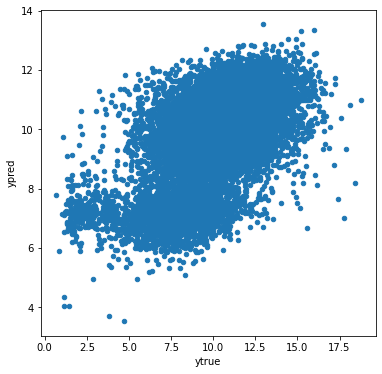

In [16]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [17]:
df_eval2.to_csv('../output/oof_genetic_AD.csv', index=False)

In [18]:
!ls -lh ../output/oof_*

-rw-r--r-- 1 igorf samuelbf 838K Feb 13 16:08 ../output/oof_genetic_AD.csv
-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 ../output/oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 838K Jan 31 22:25 ../output/oof_kronecker_dominant.csv
-rw-r--r-- 1 igorf samuelbf 839K Feb  1 15:47 ../output/oof_kronecker_epi_AA.csv
-rw-r--r-- 1 igorf samuelbf 837K Feb  1 18:55 ../output/oof_kronecker_epi_AD.csv
-rw-r--r-- 1 igorf samuelbf 838K Feb 13 15:18 ../output/oof_kronecker_epi_all.csv
-rw-r--r-- 1 igorf samuelbf 837K Feb  1 18:17 ../output/oof_kronecker_epi_DD.csv
-rw-r--r-- 1 igorf samuelbf 908K Jan 31 15:32 ../output/oof_solution_4th_sub.csv
